# Solving eigenvalue problems using Neural Network

In this jupyter notebook it will be demonstrated how we obtain our results in the report that corresponds to finding the eigenvalues of a given matrix. 

First off, we will need to import some libraries.

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import axes3d
import tqdm as tqdm
from matplotlib import rc

/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/oliver/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Then, we would like the format of the figures to be neat and in correct font. 

In [3]:
#Latex font for plots
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('font', family='serif')
plt.rcParams.update({'font.size': 10}) # Setting all font sizes

We can then make two different arrays where the analytical eigenvalues of one of them are already known. 

In [4]:
is_it_known = False 
matrix_size = 6

if is_it_known==True:
    # Defining analytical eigenvalues
    j = np.linspace(1,matrix_size,matrix_size)
    jpi = j*np.pi
    x_analytic = 2-2*tf.cos(jpi/(len(j)+1))
    
    # Defining a 6x6 matrix with only zeros
    A = np.zeros((matrix_size, matrix_size))
    
    for i in range(0,matrix_size-1):
        A[i][i+1] = -1
        A[i][i] = 2
        A[i+1][i] = -1

    A[matrix_size-1][matrix_size-1] = 2
    
if is_it_known==False:
    A = np.random.random_sample((matrix_size,matrix_size))
    A = (A.T + A)/2.

# Finding analytical eigenvector using Numpy
numpy_eigenvalue, numpy_vector = np.linalg.eig(A)
print(A)

[[0.75398251 0.5003389  0.28387417 0.53287994 0.29848398 0.42206459]
 [0.5003389  0.46137929 0.29049796 0.50462071 0.55345093 0.54527108]
 [0.28387417 0.29049796 0.49245419 0.77974503 0.20252763 0.75420221]
 [0.53287994 0.50462071 0.77974503 0.58245847 0.55246086 0.12368879]
 [0.29848398 0.55345093 0.20252763 0.55246086 0.32691042 0.43918434]
 [0.42206459 0.54527108 0.75420221 0.12368879 0.43918434 0.66447835]]


The program under runs the neural network and tries to estimate the eigenvalue of the matrix given above. 

It is worth to mention that tensorflow does not allow to reuse the tensors, so with a re-run one should also restart the kernel.

In [5]:
# Defining variables
run_iter = 100
num_iter = 100000
num_hidden_neurons = [100] # Number of hidden neurons in each layer
lambdas = np.zeros((run_iter,num_iter))

I = np.identity(matrix_size)
dt = np.ones(matrix_size)
x0 = np.random.rand(matrix_size)
x0 = x0/np.sqrt(np.sum(x0*x0)) #normalized

# The construction phase
I_tf = tf.convert_to_tensor(I)
x0_tf = tf.convert_to_tensor(np.random.random_sample(size = (1,matrix_size)))
dt_tf = tf.reshape(tf.convert_to_tensor(dt),shape=(-1,1))


with tf.variable_scope('dnn'):
    num_hidden_layers = np.size(num_hidden_neurons)

    previous_layer = x0_tf

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer

    dnn_output = tf.layers.dense(previous_layer, matrix_size)

def cost_func(x):

    xTxA = (tf.tensordot(tf.transpose(x), x, axes=1)*A)
    xTAxI = (1- tf.tensordot(tf.transpose(x), tf.tensordot(A, x, axes=1), axes=1))*np.eye(6)
    f = tf.tensordot((xTxA + xTAxI), x, axes=1)

    return(f)  # x(t))

for runs in range(run_iter):
    with tf.name_scope('loss'):

        x_trial = tf.transpose(dnn_output)  # x(t)
        right_side = tf.transpose(cost_func(x_trial))
        x_trial = tf.transpose(x_trial)  # x(t)
        
        # Define the cost function
        loss = tf.losses.mean_squared_error(right_side, x_trial)

    ## Can also use Gradient descent, but will need to uncomment learning_rate as well.
    #learning_rate = 1e-1
    with tf.name_scope('train'):
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        optimizer = tf.train.AdamOptimizer()
        
        training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    x_dnn = None

    num_iter_needed = []
    x_trial_list = np.zeros((num_iter,6))
    ## The execution phase
    with tf.Session() as sess:
        init.run()
        for i in range(num_iter):
            sess.run(training_op)

            eigenvalue = (x_trial.eval() @ (A @ x_trial.eval().T)
                        /(x_trial.eval() @ x_trial.eval().T))[0,0]

            lambdas[runs][i] = eigenvalue

            x_dnn = x_trial.eval()
            x_dnn = x_dnn.T

            ## Normalize g_trials for comparing to normalized numpy solution
            x_dnn = x_dnn/np.sqrt(np.sum(x_dnn*x_dnn))
            l = loss.eval()
            
            if i % 100 == 0:
                print("Step:", i, "/",num_iter, "loss: ", l, "Eigenvalue:" , eigenvalue)
            if l==0:#<1e-16:
                x_trial_list[i:]=x_trial_list[i-1]
                lambdas[runs][i:]=eigenvalue
                num_iter_needed.append(i)
                break

            for l in range(matrix_size):
                x_trial_list[i][l] =  x_dnn[l]

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step: 0 / 100000 loss:  0.32002223 Eigenvalue: 0.5471450444454955
Step: 100 / 100000 loss:  7.103576e-05 Eigenvalue: 1.1100110895662645
Step: 200 / 100000 loss:  1.7721171e-05 Eigenvalue: 0.9466947432150353
Step: 300 / 100000 loss:  7.549879e-06 Eigenvalue: 0.8332218531689439
Step: 400 / 100000 loss:  4.0015325e-06 Eigenvalue: 0.7450135438142641
Step: 500 / 100000 loss:  2.3979394e-06 Eigenvalue: 0.6735154586491735
Step: 600 / 100000 loss:  1.5544418e-06 Eigenvalue: 0.6142124804595551
Step: 700 / 100000 loss:  1.0638984e-06 Eigenvalue: 0.5643380382770943
Step: 800 / 100000 loss:  7.5752e-07 Eigenvalue: 0.522034499192314
Step: 900 / 100000 loss:  5.557298e-07 Eigenvalue: 0.48597275114639654
Step: 1000 / 100000 loss:  4.1

Step: 7400 / 100000 loss:  2.0207576e-09 Eigenvalue: 0.3440973083002413
Step: 7500 / 100000 loss:  1.9232544e-09 Eigenvalue: 0.3447882084704435
Step: 7600 / 100000 loss:  1.8297404e-09 Eigenvalue: 0.34546646650971913
Step: 7700 / 100000 loss:  1.7399686e-09 Eigenvalue: 0.34613100667854985
Step: 7800 / 100000 loss:  1.6539409e-09 Eigenvalue: 0.34678069874441375
Step: 7900 / 100000 loss:  1.5715411e-09 Eigenvalue: 0.3474144009381392
Step: 8000 / 100000 loss:  1.4927308e-09 Eigenvalue: 0.34803096152393226
Step: 8100 / 100000 loss:  1.4174858e-09 Eigenvalue: 0.3486292474983017
Step: 8200 / 100000 loss:  1.3457062e-09 Eigenvalue: 0.34920816880661787
Step: 8300 / 100000 loss:  1.2773724e-09 Eigenvalue: 0.3497666891603477
Step: 8400 / 100000 loss:  1.2122917e-09 Eigenvalue: 0.3503038516318767
Step: 8500 / 100000 loss:  1.1505576e-09 Eigenvalue: 0.3508187913300395
Step: 8600 / 100000 loss:  1.0919049e-09 Eigenvalue: 0.35131074723662764
Step: 8700 / 100000 loss:  1.0363599e-09 Eigenvalue: 0.351

Step: 18700 / 100000 loss:  2.0294094e-12 Eigenvalue: 0.3508624181394653
Step: 18800 / 100000 loss:  1.8867095e-12 Eigenvalue: 0.3507296784329092
Step: 18900 / 100000 loss:  1.7528674e-12 Eigenvalue: 0.35059469068681737
Step: 19000 / 100000 loss:  1.6294865e-12 Eigenvalue: 0.35045745108213394
Step: 19100 / 100000 loss:  1.5151171e-12 Eigenvalue: 0.3503178495534946
Step: 19200 / 100000 loss:  1.4082881e-12 Eigenvalue: 0.350175788417094
Step: 19300 / 100000 loss:  1.3084213e-12 Eigenvalue: 0.35003131316325736
Step: 19400 / 100000 loss:  1.2163728e-12 Eigenvalue: 0.3498843981352412
Step: 19500 / 100000 loss:  1.1305192e-12 Eigenvalue: 0.3497350014975093
Step: 19600 / 100000 loss:  1.05086e-12 Eigenvalue: 0.34958290607894077
Step: 19700 / 100000 loss:  9.762648e-13 Eigenvalue: 0.3494282310469301
Step: 19800 / 100000 loss:  9.07847e-13 Eigenvalue: 0.3492708589246364
Step: 19900 / 100000 loss:  8.4318343e-13 Eigenvalue: 0.3491106932010035
Step: 20000 / 100000 loss:  7.8389275e-13 Eigenvalue:

Step: 30000 / 100000 loss:  8.901525e-16 Eigenvalue: 0.3127022216431248
Step: 30100 / 100000 loss:  8.4500515e-16 Eigenvalue: 0.3122222700796734
Step: 30200 / 100000 loss:  7.978288e-16 Eigenvalue: 0.3117458499035432
Step: 30300 / 100000 loss:  7.558086e-16 Eigenvalue: 0.31127321329403895
Step: 30400 / 100000 loss:  7.145598e-16 Eigenvalue: 0.31080469471209565
Step: 30500 / 100000 loss:  6.874655e-16 Eigenvalue: 0.3103402805362003
Step: 30600 / 100000 loss:  6.4938797e-16 Eigenvalue: 0.30988003784178714
Step: 30700 / 100000 loss:  6.176022e-16 Eigenvalue: 0.30942442019415245
Step: 30800 / 100000 loss:  5.82264e-16 Eigenvalue: 0.3089736043223922
Step: 30900 / 100000 loss:  5.5650515e-16 Eigenvalue: 0.30852770689464054
Step: 31000 / 100000 loss:  5.3266456e-16 Eigenvalue: 0.3080868083272475
Step: 31100 / 100000 loss:  5.0691703e-16 Eigenvalue: 0.30765111601714556
Step: 31200 / 100000 loss:  4.841104e-16 Eigenvalue: 0.3072207138947995
Step: 31300 / 100000 loss:  4.558799e-16 Eigenvalue: 0

Step: 41400 / 100000 loss:  2.2346776e-17 Eigenvalue: 0.2872606974693871
Step: 41500 / 100000 loss:  2.2375514e-17 Eigenvalue: 0.28719940813181005
Step: 41600 / 100000 loss:  2.1693961e-17 Eigenvalue: 0.2871391346873109
Step: 41700 / 100000 loss:  2.1090167e-17 Eigenvalue: 0.28707995447064033
Step: 41800 / 100000 loss:  2.0930502e-17 Eigenvalue: 0.28702188982457505
Step: 41900 / 100000 loss:  2.0269004e-17 Eigenvalue: 0.28696492212451
Step: 42000 / 100000 loss:  1.9296938e-17 Eigenvalue: 0.28690884883453277
Step: 42100 / 100000 loss:  1.9941731e-17 Eigenvalue: 0.28685386479467384
Step: 42200 / 100000 loss:  1.978737e-17 Eigenvalue: 0.28679980682701967
Step: 42300 / 100000 loss:  1.9215374e-17 Eigenvalue: 0.2867468026164616
Step: 42400 / 100000 loss:  1.8398729e-17 Eigenvalue: 0.28669475204263445
Step: 42500 / 100000 loss:  1.8569821e-17 Eigenvalue: 0.2866436015287751
Step: 42600 / 100000 loss:  1.7696257e-17 Eigenvalue: 0.2865934157506569
Step: 42700 / 100000 loss:  1.7536158e-17 Eigen

Step: 52800 / 100000 loss:  3.0534125e-18 Eigenvalue: 0.28423325078850675
Step: 52900 / 100000 loss:  2.5293816e-18 Eigenvalue: 0.2842247084212035
Step: 53000 / 100000 loss:  2.7366222e-18 Eigenvalue: 0.284216339288134
Step: 53100 / 100000 loss:  2.7141758e-18 Eigenvalue: 0.28420811490562414
Step: 53200 / 100000 loss:  2.8015615e-18 Eigenvalue: 0.2842000438560855
Step: 53300 / 100000 loss:  2.548581e-18 Eigenvalue: 0.28419207175979394
Step: 53400 / 100000 loss:  2.6581306e-18 Eigenvalue: 0.2841842695306177
Step: 53500 / 100000 loss:  2.5560632e-18 Eigenvalue: 0.28417653871499465
Step: 53600 / 100000 loss:  2.6464132e-18 Eigenvalue: 0.2841689405576648
Step: 53700 / 100000 loss:  2.4137616e-18 Eigenvalue: 0.2841615133490707
Step: 53800 / 100000 loss:  2.6914472e-18 Eigenvalue: 0.284154194677688
Step: 53900 / 100000 loss:  2.5710273e-18 Eigenvalue: 0.28414699486375944
Step: 54000 / 100000 loss:  2.417432e-18 Eigenvalue: 0.28413988954750036
Step: 54100 / 100000 loss:  2.5391225e-18 Eigenva

Step: 64200 / 100000 loss:  4.0445823e-19 Eigenvalue: 0.28379463946733346
Step: 64300 / 100000 loss:  3.636595e-19 Eigenvalue: 0.28379334925722843
Step: 64400 / 100000 loss:  3.5476564e-19 Eigenvalue: 0.2837920811320168
Step: 64500 / 100000 loss:  5.039846e-19 Eigenvalue: 0.28379083634810287
Step: 64600 / 100000 loss:  4.953731e-19 Eigenvalue: 0.283789612404044
Step: 64700 / 100000 loss:  5.3588953e-19 Eigenvalue: 0.2837884110613667
Step: 64800 / 100000 loss:  3.959879e-19 Eigenvalue: 0.28378722178188814
Step: 64900 / 100000 loss:  3.4615412e-19 Eigenvalue: 0.28378606265190714
Step: 65000 / 100000 loss:  3.12414e-19 Eigenvalue: 0.28378490944448903
Step: 65100 / 100000 loss:  4.5457437e-19 Eigenvalue: 0.2837837703612698
Step: 65200 / 100000 loss:  3.4460125e-19 Eigenvalue: 0.2837826585803582
Step: 65300 / 100000 loss:  4.4624517e-19 Eigenvalue: 0.2837815684214021
Step: 65400 / 100000 loss:  2.9603802e-19 Eigenvalue: 0.28378049137688194
Step: 65500 / 100000 loss:  3.6591823e-19 Eigenvalu

Step: 75500 / 100000 loss:  9.275011e-20 Eigenvalue: 0.2837279353345518
Step: 75600 / 100000 loss:  5.661004e-20 Eigenvalue: 0.28372773727254985
Step: 75700 / 100000 loss:  9.4444174e-20 Eigenvalue: 0.28372753548540547
Step: 75800 / 100000 loss:  5.8304103e-20 Eigenvalue: 0.2837273345713999
Step: 75900 / 100000 loss:  9.275011e-20 Eigenvalue: 0.28372714515570635
Step: 76000 / 100000 loss:  8.9503146e-20 Eigenvalue: 0.2837269557032245
Step: 76100 / 100000 loss:  4.573978e-20 Eigenvalue: 0.28372677109925215
Step: 76200 / 100000 loss:  9.091487e-20 Eigenvalue: 0.2837265844338584
Step: 76300 / 100000 loss:  8.9503146e-20 Eigenvalue: 0.28372640494090945
Step: 76400 / 100000 loss:  4.3481024e-20 Eigenvalue: 0.283726227859364
Step: 76500 / 100000 loss:  9.091487e-20 Eigenvalue: 0.2837260512350356
Step: 76600 / 100000 loss:  8.766791e-20 Eigenvalue: 0.28372588144969224
Step: 76700 / 100000 loss:  8.766791e-20 Eigenvalue: 0.28372571225509
Step: 76800 / 100000 loss:  5.1527837e-20 Eigenvalue: 0.

Step: 86800 / 100000 loss:  1.3834872e-20 Eigenvalue: 0.2837174978361318
Step: 86900 / 100000 loss:  7.058608e-21 Eigenvalue: 0.2837174653126623
Step: 87000 / 100000 loss:  4.249282e-20 Eigenvalue: 0.2837174339937672
Step: 87100 / 100000 loss:  4.8704394e-20 Eigenvalue: 0.2837174033032
Step: 87200 / 100000 loss:  1.6093626e-20 Eigenvalue: 0.28371737472708913
Step: 87300 / 100000 loss:  7.058608e-21 Eigenvalue: 0.2837173457709512
Step: 87400 / 100000 loss:  5.096315e-20 Eigenvalue: 0.28371731650731585
Step: 87500 / 100000 loss:  5.7880586e-21 Eigenvalue: 0.28371728749757535
Step: 87600 / 100000 loss:  8.639736e-20 Eigenvalue: 0.28371725978022466
Step: 87700 / 100000 loss:  1.4823077e-20 Eigenvalue: 0.2837172323950793
Step: 87800 / 100000 loss:  7.058608e-21 Eigenvalue: 0.2837172041081078
Step: 87900 / 100000 loss:  7.708e-20 Eigenvalue: 0.2837171784640247
Step: 88000 / 100000 loss:  5.0821977e-21 Eigenvalue: 0.2837171512159131
Step: 88100 / 100000 loss:  4.249282e-20 Eigenvalue: 0.28371

Step: 98100 / 100000 loss:  7.0586077e-22 Eigenvalue: 0.28371585787261183
Step: 98200 / 100000 loss:  3.6845933e-20 Eigenvalue: 0.28371585349014466
Step: 98300 / 100000 loss:  2.8234432e-22 Eigenvalue: 0.2837158484022975
Step: 98400 / 100000 loss:  7.524476e-20 Eigenvalue: 0.28371584428550595
Step: 98500 / 100000 loss:  3.6422417e-20 Eigenvalue: 0.28371583919486515
Step: 98600 / 100000 loss:  2.8234432e-22 Eigenvalue: 0.2837158353577301
Step: 98700 / 100000 loss:  1.1999634e-20 Eigenvalue: 0.2837158318039923
Step: 98800 / 100000 loss:  7.0586077e-22 Eigenvalue: 0.2837158267321806
Step: 98900 / 100000 loss:  2.9646153e-21 Eigenvalue: 0.2837158223461821
Step: 99000 / 100000 loss:  7.0586077e-22 Eigenvalue: 0.28371581869056767
Step: 99100 / 100000 loss:  2.9646153e-21 Eigenvalue: 0.2837158142556215
Step: 99200 / 100000 loss:  2.9646153e-21 Eigenvalue: 0.2837158091030742
Step: 99300 / 100000 loss:  2.8234432e-22 Eigenvalue: 0.283715804841933
Step: 99400 / 100000 loss:  2.8234432e-22 Eigenv

Step: 9500 / 100000 loss:  3.151102e-08 Eigenvalue: 0.34779356878689016
Step: 9600 / 100000 loss:  2.9169358e-08 Eigenvalue: 0.3466892806367446
Step: 9700 / 100000 loss:  2.6999352e-08 Eigenvalue: 0.34556782348884074
Step: 9800 / 100000 loss:  2.4988516e-08 Eigenvalue: 0.34442923173354295
Step: 9900 / 100000 loss:  2.3125537e-08 Eigenvalue: 0.34327358759461224
Step: 10000 / 100000 loss:  2.139933e-08 Eigenvalue: 0.342100979669151
Step: 10100 / 100000 loss:  1.9799376e-08 Eigenvalue: 0.3409115753696316
Step: 10200 / 100000 loss:  1.8316907e-08 Eigenvalue: 0.33970555928508755
Step: 10300 / 100000 loss:  1.6943366e-08 Eigenvalue: 0.3384831495274451
Step: 10400 / 100000 loss:  1.5670034e-08 Eigenvalue: 0.3372446378295941
Step: 10500 / 100000 loss:  1.4490213e-08 Eigenvalue: 0.33599033839967424
Step: 10600 / 100000 loss:  1.3397148e-08 Eigenvalue: 0.33472064254826656
Step: 10700 / 100000 loss:  1.2383953e-08 Eigenvalue: 0.3334359684902457
Step: 10800 / 100000 loss:  1.1445018e-08 Eigenvalue

Step: 2800 / 100000 loss:  7.694569e-06 Eigenvalue: 0.3471354971249106
Step: 2900 / 100000 loss:  6.833485e-06 Eigenvalue: 0.3567911054884403
Step: 3000 / 100000 loss:  6.078168e-06 Eigenvalue: 0.3662339062451994
Step: 3100 / 100000 loss:  5.4135267e-06 Eigenvalue: 0.37546362467705846
Step: 3200 / 100000 loss:  4.8269762e-06 Eigenvalue: 0.3844792559711235
Step: 3300 / 100000 loss:  4.3079312e-06 Eigenvalue: 0.3932791199931179
Step: 3400 / 100000 loss:  3.847497e-06 Eigenvalue: 0.40186092821133035
Step: 3500 / 100000 loss:  3.4380985e-06 Eigenvalue: 0.4102218292340188
Step: 3600 / 100000 loss:  3.0733238e-06 Eigenvalue: 0.4183584732982131
Step: 3700 / 100000 loss:  2.7476765e-06 Eigenvalue: 0.4262670655071649
Step: 3800 / 100000 loss:  2.4564463e-06 Eigenvalue: 0.4339434194031664
Step: 3900 / 100000 loss:  2.1955816e-06 Eigenvalue: 0.44138302913368155
Step: 4000 / 100000 loss:  1.9615911e-06 Eigenvalue: 0.44858112514387105
Step: 4100 / 100000 loss:  1.7514284e-06 Eigenvalue: 0.455532752

Step: 14300 / 100000 loss:  3.6977074e-10 Eigenvalue: 0.5568312398914625
Step: 14400 / 100000 loss:  3.0399205e-10 Eigenvalue: 0.5568764785821742
Step: 14500 / 100000 loss:  2.4714508e-10 Eigenvalue: 0.5569153954569331
Step: 14600 / 100000 loss:  1.9835954e-10 Eigenvalue: 0.556948461052445
Step: 14700 / 100000 loss:  1.5712369e-10 Eigenvalue: 0.5569761893426838
Step: 14800 / 100000 loss:  1.2264756e-10 Eigenvalue: 0.5569991221564381
Step: 14900 / 100000 loss:  9.4341736e-11 Eigenvalue: 0.5570178140303916
Step: 15000 / 100000 loss:  7.146506e-11 Eigenvalue: 0.5570328180624153
Step: 15100 / 100000 loss:  5.3172966e-11 Eigenvalue: 0.5570446695953741
Step: 15200 / 100000 loss:  3.8898745e-11 Eigenvalue: 0.5570538730423209
Step: 15300 / 100000 loss:  2.7950966e-11 Eigenvalue: 0.55706089436787
Step: 15400 / 100000 loss:  1.9719547e-11 Eigenvalue: 0.5570661527050665
Step: 15500 / 100000 loss:  1.3600124e-11 Eigenvalue: 0.5570700140155337
Step: 15600 / 100000 loss:  9.206007e-12 Eigenvalue: 0.

Step: 8200 / 100000 loss:  1.5420534e-07 Eigenvalue: 0.49889872766973636
Step: 8300 / 100000 loss:  1.4518521e-07 Eigenvalue: 0.49873269848526164
Step: 8400 / 100000 loss:  1.3661557e-07 Eigenvalue: 0.49856337411566964
Step: 8500 / 100000 loss:  1.284799e-07 Eigenvalue: 0.498390691881812
Step: 8600 / 100000 loss:  1.2076373e-07 Eigenvalue: 0.49821459795443773
Step: 8700 / 100000 loss:  1.134506e-07 Eigenvalue: 0.4980350290981893
Step: 8800 / 100000 loss:  1.0652781e-07 Eigenvalue: 0.49785191814473523
Step: 8900 / 100000 loss:  9.9975956e-08 Eigenvalue: 0.4976652035129828
Step: 9000 / 100000 loss:  9.378249e-08 Eigenvalue: 0.49747481351538686
Step: 9100 / 100000 loss:  8.793139e-08 Eigenvalue: 0.49728068305217693
Step: 9200 / 100000 loss:  8.240797e-08 Eigenvalue: 0.49708273984825774
Step: 9300 / 100000 loss:  7.7197285e-08 Eigenvalue: 0.49688091050569594
Step: 9400 / 100000 loss:  7.2286085e-08 Eigenvalue: 0.49667513265230867
Step: 9500 / 100000 loss:  6.765948e-08 Eigenvalue: 0.496465

Step: 19600 / 100000 loss:  2.1225355e-11 Eigenvalue: 0.4531701293065064
Step: 19700 / 100000 loss:  1.8653237e-11 Eigenvalue: 0.45288055093677637
Step: 19800 / 100000 loss:  1.6316904e-11 Eigenvalue: 0.45261114407725045
Step: 19900 / 100000 loss:  1.4201434e-11 Eigenvalue: 0.4523619805579828
Step: 20000 / 100000 loss:  1.229428e-11 Eigenvalue: 0.45213301693982133
Step: 20100 / 100000 loss:  1.0566326e-11 Eigenvalue: 0.4519240319464044
Step: 20200 / 100000 loss:  9.024542e-12 Eigenvalue: 0.451734707156698
Step: 20300 / 100000 loss:  7.650138e-12 Eigenvalue: 0.4515645123523887
Step: 20400 / 100000 loss:  6.4331054e-12 Eigenvalue: 0.45141280958863933
Step: 20500 / 100000 loss:  5.366174e-12 Eigenvalue: 0.45127879882968064
Step: 20600 / 100000 loss:  4.4318178e-12 Eigenvalue: 0.4511615415963989
Step: 20700 / 100000 loss:  3.621177e-12 Eigenvalue: 0.45106000521431894
Step: 20800 / 100000 loss:  2.9308142e-12 Eigenvalue: 0.4509730284190717
Step: 20900 / 100000 loss:  2.3420866e-12 Eigenvalu

Step: 6400 / 100000 loss:  1.8686691e-08 Eigenvalue: 0.5470958352518451
Step: 6500 / 100000 loss:  1.7130338e-08 Eigenvalue: 0.5475460552387635
Step: 6600 / 100000 loss:  1.5692875e-08 Eigenvalue: 0.5479905937801289
Step: 6700 / 100000 loss:  1.43649315e-08 Eigenvalue: 0.5484289539244802
Step: 6800 / 100000 loss:  1.3138859e-08 Eigenvalue: 0.5488606326163772
Step: 6900 / 100000 loss:  1.2006397e-08 Eigenvalue: 0.5492851244832424
Step: 7000 / 100000 loss:  1.0961372e-08 Eigenvalue: 0.5497019182906409
Step: 7100 / 100000 loss:  9.997128e-09 Eigenvalue: 0.550110502721911
Step: 7200 / 100000 loss:  9.107308e-09 Eigenvalue: 0.5505103667813959
Step: 7300 / 100000 loss:  8.287375e-09 Eigenvalue: 0.5509010051036984
Step: 7400 / 100000 loss:  7.531821e-09 Eigenvalue: 0.5512819190906835
Step: 7500 / 100000 loss:  6.83548e-09 Eigenvalue: 0.5516526156585011
Step: 7600 / 100000 loss:  6.1939858e-09 Eigenvalue: 0.5520126192512773
Step: 7700 / 100000 loss:  5.6041176e-09 Eigenvalue: 0.552361465290947

Step: 4600 / 100000 loss:  9.0187774e-07 Eigenvalue: 0.5075582430148581
Step: 4700 / 100000 loss:  8.378395e-07 Eigenvalue: 0.5081266327128471
Step: 4800 / 100000 loss:  7.795588e-07 Eigenvalue: 0.5086688394254106
Step: 4900 / 100000 loss:  7.2644656e-07 Eigenvalue: 0.5091863512876421
Step: 5000 / 100000 loss:  6.779858e-07 Eigenvalue: 0.5096806975780249
Step: 5100 / 100000 loss:  6.3370965e-07 Eigenvalue: 0.5101534450254896
Step: 5200 / 100000 loss:  5.931954e-07 Eigenvalue: 0.5106061891638007
Step: 5300 / 100000 loss:  5.5606813e-07 Eigenvalue: 0.5110405539603974
Step: 5400 / 100000 loss:  5.219851e-07 Eigenvalue: 0.5114581783245644
Step: 5500 / 100000 loss:  4.9063806e-07 Eigenvalue: 0.5118607148613151
Step: 5600 / 100000 loss:  4.6175737e-07 Eigenvalue: 0.5122498184379191
Step: 5700 / 100000 loss:  4.350835e-07 Eigenvalue: 0.5126271388545084
Step: 5800 / 100000 loss:  4.104031e-07 Eigenvalue: 0.5129943163425297
Step: 5900 / 100000 loss:  3.8751034e-07 Eigenvalue: 0.5133529649989861

Step: 16000 / 100000 loss:  4.2056462e-13 Eigenvalue: 0.5570778660267268
Step: 16100 / 100000 loss:  2.2640338e-13 Eigenvalue: 0.5570781796731696
Step: 16200 / 100000 loss:  1.1936864e-13 Eigenvalue: 0.5570783555615435
Step: 16300 / 100000 loss:  6.071648e-14 Eigenvalue: 0.5570784509791261
Step: 16400 / 100000 loss:  2.882185e-14 Eigenvalue: 0.5570785009092635
Step: 16500 / 100000 loss:  1.4019457e-14 Eigenvalue: 0.5570785261059814
Step: 16600 / 100000 loss:  6.537016e-15 Eigenvalue: 0.5570785383233713
Step: 16700 / 100000 loss:  2.5997722e-15 Eigenvalue: 0.5570785440069792
Step: 16800 / 100000 loss:  1.0558684e-15 Eigenvalue: 0.557078546527262
Step: 16900 / 100000 loss:  4.834096e-16 Eigenvalue: 0.5570785476026571
Step: 17000 / 100000 loss:  1.6479873e-16 Eigenvalue: 0.5570785480385188
Step: 17100 / 100000 loss:  4.8572257e-17 Eigenvalue: 0.5570785482087145
Step: 17200 / 100000 loss:  2.1394922e-17 Eigenvalue: 0.5570785482703003
Step: 17300 / 100000 loss:  1.3877788e-17 Eigenvalue: 0.

Step: 4000 / 100000 loss:  1.0455403e-08 Eigenvalue: 0.32883657584478737
Step: 4100 / 100000 loss:  9.809353e-09 Eigenvalue: 0.3285064944103848
Step: 4200 / 100000 loss:  9.206144e-09 Eigenvalue: 0.32812547345968435
Step: 4300 / 100000 loss:  8.641307e-09 Eigenvalue: 0.32769880123528994
Step: 4400 / 100000 loss:  8.111291e-09 Eigenvalue: 0.32723108506028153
Step: 4500 / 100000 loss:  7.612992e-09 Eigenvalue: 0.3267263613477876
Step: 4600 / 100000 loss:  7.144008e-09 Eigenvalue: 0.3261881632047163
Step: 4700 / 100000 loss:  6.702253e-09 Eigenvalue: 0.32561961943755935
Step: 4800 / 100000 loss:  6.286029e-09 Eigenvalue: 0.32502349562176386
Step: 4900 / 100000 loss:  5.8935687e-09 Eigenvalue: 0.3244022496953435
Step: 5000 / 100000 loss:  5.5237996e-09 Eigenvalue: 0.323758085049901
Step: 5100 / 100000 loss:  5.174782e-09 Eigenvalue: 0.32309298319095875
Step: 5200 / 100000 loss:  4.845943e-09 Eigenvalue: 0.3224087347604875
Step: 5300 / 100000 loss:  4.5360093e-09 Eigenvalue: 0.3217069657364

Step: 15400 / 100000 loss:  1.412354e-16 Eigenvalue: 0.28371556294462774
Step: 15500 / 100000 loss:  7.083454e-17 Eigenvalue: 0.2837155579429785
Step: 15600 / 100000 loss:  4.4307728e-17 Eigenvalue: 0.2837155549476922
Step: 15700 / 100000 loss:  2.1178082e-17 Eigenvalue: 0.28371555322223585
Step: 15800 / 100000 loss:  9.324139e-18 Eigenvalue: 0.2837155522470521
Step: 15900 / 100000 loss:  6.975034e-18 Eigenvalue: 0.283715551721521
Step: 16000 / 100000 loss:  5.565571e-18 Eigenvalue: 0.28371555145228905
Step: 16100 / 100000 loss:  6.107672e-18 Eigenvalue: 0.2837155513105102
Step: 16200 / 100000 loss:  3.2526065e-18 Eigenvalue: 0.283715551248638
Step: 16300 / 100000 loss:  7.589415e-19 Eigenvalue: 0.28371555121740877
Step: 16400 / 100000 loss:  7.228015e-20 Eigenvalue: 0.2837155512009747
Step: 0 / 100000 loss:  0.05722807 Eigenvalue: 2.763562381947862
Step: 100 / 100000 loss:  4.1047943e-07 Eigenvalue: 2.823757152484333
Step: 200 / 100000 loss:  2.1741868e-12 Eigenvalue: 2.82384291339114

Step: 10000 / 100000 loss:  2.7128868e-09 Eigenvalue: 0.4541962974448571
Step: 10100 / 100000 loss:  2.4524542e-09 Eigenvalue: 0.45389291741195376
Step: 10200 / 100000 loss:  2.2089086e-09 Eigenvalue: 0.45360059219697246
Step: 10300 / 100000 loss:  1.982161e-09 Eigenvalue: 0.45332018364209953
Step: 10400 / 100000 loss:  1.7713377e-09 Eigenvalue: 0.45305250914349043
Step: 10500 / 100000 loss:  1.5757831e-09 Eigenvalue: 0.452798319879047
Step: 10600 / 100000 loss:  1.3948593e-09 Eigenvalue: 0.45255827216872924
Step: 10700 / 100000 loss:  1.2281781e-09 Eigenvalue: 0.4523329670327352
Step: 10800 / 100000 loss:  1.0750519e-09 Eigenvalue: 0.45212284736801517
Step: 10900 / 100000 loss:  9.351925e-10 Eigenvalue: 0.45192826520335677
Step: 11000 / 100000 loss:  8.0786494e-10 Eigenvalue: 0.45174941361952614
Step: 11100 / 100000 loss:  6.9269385e-10 Eigenvalue: 0.45158634911335627
Step: 11200 / 100000 loss:  5.8916044e-10 Eigenvalue: 0.451438952699536
Step: 11300 / 100000 loss:  4.9665794e-10 Eige

Step: 6400 / 100000 loss:  5.3209526e-10 Eigenvalue: -0.18426156225000184
Step: 6500 / 100000 loss:  3.6569772e-10 Eigenvalue: -0.18425807276084663
Step: 6600 / 100000 loss:  2.46723e-10 Eigenvalue: -0.1842555198315848
Step: 6700 / 100000 loss:  1.6317946e-10 Eigenvalue: -0.18425369869361383
Step: 6800 / 100000 loss:  1.0562784e-10 Eigenvalue: -0.18425243142730977
Step: 6900 / 100000 loss:  6.6868504e-11 Eigenvalue: -0.1842515713578861
Step: 7000 / 100000 loss:  4.13217e-11 Eigenvalue: -0.18425100216258594
Step: 7100 / 100000 loss:  2.4932148e-11 Eigenvalue: -0.18425063512650913
Step: 7200 / 100000 loss:  1.4633956e-11 Eigenvalue: -0.1842504046769188
Step: 7300 / 100000 loss:  8.357073e-12 Eigenvalue: -0.18425026400138494
Step: 7400 / 100000 loss:  4.6353507e-12 Eigenvalue: -0.18425018056287665
Step: 7500 / 100000 loss:  2.4859288e-12 Eigenvalue: -0.18425013257800354
Step: 7600 / 100000 loss:  1.2998769e-12 Eigenvalue: -0.18425010584315718
Step: 7700 / 100000 loss:  6.5168937e-13 Eigen

Step: 8600 / 100000 loss:  2.9215064e-09 Eigenvalue: 0.28378362572824506
Step: 8700 / 100000 loss:  2.010013e-09 Eigenvalue: 0.2837621992837668
Step: 8800 / 100000 loss:  1.3532607e-09 Eigenvalue: 0.28374684360097585
Step: 8900 / 100000 loss:  8.906897e-10 Eigenvalue: 0.2837360795725943
Step: 9000 / 100000 loss:  5.7241784e-10 Eigenvalue: 0.28372870671694134
Step: 9100 / 100000 loss:  3.5869252e-10 Eigenvalue: 0.28372377774695384
Step: 9200 / 100000 loss:  2.1910374e-10 Eigenvalue: 0.28372056502780757
Step: 9300 / 100000 loss:  1.301889e-10 Eigenvalue: 0.2837185255937166
Step: 9400 / 100000 loss:  7.516964e-11 Eigenvalue: 0.2837172665308068
Step: 9500 / 100000 loss:  4.2117625e-11 Eigenvalue: 0.28371651143660176
Step: 9600 / 100000 loss:  2.2872529e-11 Eigenvalue: 0.28371607222748696
Step: 9700 / 100000 loss:  1.2033594e-11 Eigenvalue: 0.28371582476930823
Step: 9800 / 100000 loss:  6.1008165e-12 Eigenvalue: 0.28371568996773416
Step: 9900 / 100000 loss:  2.98465e-12 Eigenvalue: 0.283715

Step: 8400 / 100000 loss:  9.710215e-10 Eigenvalue: 0.45064232039184654
Step: 8500 / 100000 loss:  8.1390433e-10 Eigenvalue: 0.45063729679553466
Step: 8600 / 100000 loss:  6.766538e-10 Eigenvalue: 0.45063288683373076
Step: 8700 / 100000 loss:  5.575358e-10 Eigenvalue: 0.45062904795257486
Step: 8800 / 100000 loss:  4.5535808e-10 Eigenvalue: 0.4506257355216061
Step: 8900 / 100000 loss:  3.681886e-10 Eigenvalue: 0.45062290382684367
Step: 9000 / 100000 loss:  2.9470326e-10 Eigenvalue: 0.4506205069283697
Step: 9100 / 100000 loss:  2.333659e-10 Eigenvalue: 0.4506184989330668
Step: 9200 / 100000 loss:  1.8269541e-10 Eigenvalue: 0.4506168351856492
Step: 9300 / 100000 loss:  1.4137873e-10 Eigenvalue: 0.45061547251300593
Step: 9400 / 100000 loss:  1.0804663e-10 Eigenvalue: 0.4506143700432571
Step: 9500 / 100000 loss:  8.139991e-11 Eigenvalue: 0.45061348952069397
Step: 9600 / 100000 loss:  6.050169e-11 Eigenvalue: 0.4506127957719544
Step: 9700 / 100000 loss:  4.4300008e-11 Eigenvalue: 0.450612257

Step: 2400 / 100000 loss:  9.261907e-09 Eigenvalue: 0.5151597428783553
Step: 2500 / 100000 loss:  8.610188e-09 Eigenvalue: 0.5158499148329607
Step: 2600 / 100000 loss:  8.038918e-09 Eigenvalue: 0.5165187109513824
Step: 2700 / 100000 loss:  7.529212e-09 Eigenvalue: 0.5171741174011384
Step: 2800 / 100000 loss:  7.067539e-09 Eigenvalue: 0.5178217901632394
Step: 2900 / 100000 loss:  6.6440182e-09 Eigenvalue: 0.5184655209319872
Step: 3000 / 100000 loss:  6.251628e-09 Eigenvalue: 0.5191076962155481
Step: 3100 / 100000 loss:  5.88547e-09 Eigenvalue: 0.5197496385280173
Step: 3200 / 100000 loss:  5.5419207e-09 Eigenvalue: 0.520391893298984
Step: 3300 / 100000 loss:  5.218695e-09 Eigenvalue: 0.5210344625190838
Step: 3400 / 100000 loss:  4.9137294e-09 Eigenvalue: 0.5216769856874418
Step: 3500 / 100000 loss:  4.625675e-09 Eigenvalue: 0.5223188928318611
Step: 3600 / 100000 loss:  4.3536734e-09 Eigenvalue: 0.5229594771095921
Step: 3700 / 100000 loss:  4.0967096e-09 Eigenvalue: 0.52359800293258
Step:

Step: 0 / 100000 loss:  5.6119876 Eigenvalue: 1.57396842400903
Step: 100 / 100000 loss:  0.00021097423 Eigenvalue: 0.03813417940313268
Step: 200 / 100000 loss:  0.00011300197 Eigenvalue: -0.020393555634280833
Step: 300 / 100000 loss:  6.5402506e-05 Eigenvalue: -0.05611369629262717
Step: 400 / 100000 loss:  4.625389e-05 Eigenvalue: -0.07402018759086756
Step: 500 / 100000 loss:  3.7336573e-05 Eigenvalue: -0.08365218635058226
Step: 600 / 100000 loss:  3.134507e-05 Eigenvalue: -0.09029348740149039
Step: 700 / 100000 loss:  2.6526948e-05 Eigenvalue: -0.09590655465318243
Step: 800 / 100000 loss:  2.251821e-05 Eigenvalue: -0.10111416165366
Step: 900 / 100000 loss:  1.9173549e-05 Eigenvalue: -0.10609512820629252
Step: 1000 / 100000 loss:  1.6381498e-05 Eigenvalue: -0.1108900918629647
Step: 1100 / 100000 loss:  1.4046539e-05 Eigenvalue: -0.11550088408801552
Step: 1200 / 100000 loss:  1.2088057e-05 Eigenvalue: -0.11992153466533988
Step: 1300 / 100000 loss:  1.0439308e-05 Eigenvalue: -0.124146957

Step: 2900 / 100000 loss:  9.9135626e-08 Eigenvalue: -0.22893692846589725
Step: 3000 / 100000 loss:  8.935007e-08 Eigenvalue: -0.23425996243372818
Step: 3100 / 100000 loss:  8.066912e-08 Eigenvalue: -0.23956069997007065
Step: 3200 / 100000 loss:  7.2948346e-08 Eigenvalue: -0.24484259558030028
Step: 3300 / 100000 loss:  6.6064366e-08 Eigenvalue: -0.2501088325268337
Step: 3400 / 100000 loss:  5.991266e-08 Eigenvalue: -0.25536232478636084
Step: 3500 / 100000 loss:  5.4403767e-08 Eigenvalue: -0.26060573999890874
Step: 3600 / 100000 loss:  4.9460983e-08 Eigenvalue: -0.2658415231112462
Step: 3700 / 100000 loss:  4.501688e-08 Eigenvalue: -0.2710719111802353
Step: 3800 / 100000 loss:  4.101552e-08 Eigenvalue: -0.2762989373202866
Step: 3900 / 100000 loss:  3.7406032e-08 Eigenvalue: -0.28152445245831537
Step: 4000 / 100000 loss:  3.4145557e-08 Eigenvalue: -0.2867501119157869
Step: 4100 / 100000 loss:  3.119545e-08 Eigenvalue: -0.2919774221122879
Step: 4200 / 100000 loss:  2.8522997e-08 Eigenvalu

Step: 14200 / 100000 loss:  4.8876025e-12 Eigenvalue: -0.6455588198268947
Step: 14300 / 100000 loss:  4.1970438e-12 Eigenvalue: -0.6460816109945263
Step: 14400 / 100000 loss:  3.5780673e-12 Eigenvalue: -0.6465537235816332
Step: 14500 / 100000 loss:  3.0259753e-12 Eigenvalue: -0.6469767631269485
Step: 14600 / 100000 loss:  2.5411984e-12 Eigenvalue: -0.6473527162794388
Step: 14700 / 100000 loss:  2.1158884e-12 Eigenvalue: -0.6476838858024772
Step: 14800 / 100000 loss:  1.7455472e-12 Eigenvalue: -0.6479729220303976
Step: 14900 / 100000 loss:  1.4246684e-12 Eigenvalue: -0.6482227269021603
Step: 15000 / 100000 loss:  1.1509097e-12 Eigenvalue: -0.6484363957332094
Step: 15100 / 100000 loss:  9.195445e-13 Eigenvalue: -0.6486171645971752
Step: 15200 / 100000 loss:  7.275686e-13 Eigenvalue: -0.6487683340754821
Step: 15300 / 100000 loss:  5.674024e-13 Eigenvalue: -0.6488932250819219
Step: 15400 / 100000 loss:  4.3705103e-13 Eigenvalue: -0.6489950765518855
Step: 15500 / 100000 loss:  3.3180706e-13

Step: 7600 / 100000 loss:  1.1495712e-12 Eigenvalue: 0.45061077658634113
Step: 7700 / 100000 loss:  4.659606e-13 Eigenvalue: 0.45061077634802055
Step: 7800 / 100000 loss:  1.7060427e-13 Eigenvalue: 0.4506107762502847
Step: 7900 / 100000 loss:  6.084947e-14 Eigenvalue: 0.4506107762122088
Step: 8000 / 100000 loss:  2.1806631e-14 Eigenvalue: 0.4506107761981959
Step: 8100 / 100000 loss:  7.336724e-15 Eigenvalue: 0.45061077619327294
Step: 8200 / 100000 loss:  2.3777276e-15 Eigenvalue: 0.4506107761916637
Step: 8300 / 100000 loss:  7.86408e-16 Eigenvalue: 0.45061077619116996
Step: 8400 / 100000 loss:  3.7007435e-17 Eigenvalue: 0.45061077619102013
Step: 0 / 100000 loss:  1.9849471 Eigenvalue: 0.9441377718578821
Step: 100 / 100000 loss:  0.00022200025 Eigenvalue: 0.41597804286509005
Step: 200 / 100000 loss:  6.2508865e-05 Eigenvalue: 0.47941284872059303
Step: 300 / 100000 loss:  2.4723582e-05 Eigenvalue: 0.5067104270032491
Step: 400 / 100000 loss:  1.2384462e-05 Eigenvalue: 0.5189644586004605
S

Step: 10600 / 100000 loss:  1.6514567e-15 Eigenvalue: 0.5570785482453681
Step: 10700 / 100000 loss:  7.86408e-16 Eigenvalue: 0.5570785482770053
Step: 10800 / 100000 loss:  2.821817e-16 Eigenvalue: 0.5570785482914724
Step: 10900 / 100000 loss:  1.2027417e-16 Eigenvalue: 0.557078548297369
Step: 11000 / 100000 loss:  5.551115e-17 Eigenvalue: 0.5570785482997522
Step: 11100 / 100000 loss:  7.8640795e-17 Eigenvalue: 0.5570785483007565
Step: 0 / 100000 loss:  0.013992042 Eigenvalue: 0.27751902531968986
Step: 100 / 100000 loss:  1.8102754e-06 Eigenvalue: 0.14840907729170078
Step: 200 / 100000 loss:  5.2817137e-07 Eigenvalue: 0.14255448251649458
Step: 300 / 100000 loss:  2.5030673e-07 Eigenvalue: 0.1497111789156571
Step: 400 / 100000 loss:  1.4320172e-07 Eigenvalue: 0.15589583493709944
Step: 500 / 100000 loss:  9.156071e-08 Eigenvalue: 0.16104563109469153
Step: 600 / 100000 loss:  6.2996875e-08 Eigenvalue: 0.1654486450665803
Step: 700 / 100000 loss:  4.565291e-08 Eigenvalue: 0.1693152722811318


Step: 10800 / 100000 loss:  4.266353e-12 Eigenvalue: 0.32923323206220917
Step: 10900 / 100000 loss:  4.0415488e-12 Eigenvalue: 0.3286048960059057
Step: 11000 / 100000 loss:  3.829422e-12 Eigenvalue: 0.32793469148093546
Step: 11100 / 100000 loss:  3.6292185e-12 Eigenvalue: 0.3272250233668835
Step: 11200 / 100000 loss:  3.4398005e-12 Eigenvalue: 0.3264784356649635
Step: 11300 / 100000 loss:  3.2602506e-12 Eigenvalue: 0.3256971983528003
Step: 11400 / 100000 loss:  3.090218e-12 Eigenvalue: 0.3248836724537756
Step: 11500 / 100000 loss:  2.9276115e-12 Eigenvalue: 0.3240402560472508
Step: 11600 / 100000 loss:  2.7731038e-12 Eigenvalue: 0.3231691581893936
Step: 11700 / 100000 loss:  2.6256595e-12 Eigenvalue: 0.3222725810263223
Step: 11800 / 100000 loss:  2.4865067e-12 Eigenvalue: 0.32135289686927687
Step: 11900 / 100000 loss:  2.3520315e-12 Eigenvalue: 0.32041194092804925
Step: 12000 / 100000 loss:  2.2241668e-12 Eigenvalue: 0.3194520741580019
Step: 12100 / 100000 loss:  2.1015763e-12 Eigenval

Step: 200 / 100000 loss:  0.00013098247 Eigenvalue: 0.37156860376628253
Step: 300 / 100000 loss:  8.738489e-05 Eigenvalue: 0.3723225293324333
Step: 400 / 100000 loss:  6.666541e-05 Eigenvalue: 0.37162877141355843
Step: 500 / 100000 loss:  5.2754705e-05 Eigenvalue: 0.3709376568520492
Step: 600 / 100000 loss:  4.229249e-05 Eigenvalue: 0.3704127838458477
Step: 700 / 100000 loss:  3.4228644e-05 Eigenvalue: 0.3700138004620975
Step: 800 / 100000 loss:  2.7958553e-05 Eigenvalue: 0.36969985994770016
Step: 900 / 100000 loss:  2.304388e-05 Eigenvalue: 0.369446430719679
Step: 1000 / 100000 loss:  1.9157354e-05 Eigenvalue: 0.36923899012261735
Step: 1100 / 100000 loss:  1.6055266e-05 Eigenvalue: 0.3690681890968022
Step: 1200 / 100000 loss:  1.3556313e-05 Eigenvalue: 0.3689274471237469
Step: 1300 / 100000 loss:  1.1525146e-05 Eigenvalue: 0.36881181863479356
Step: 1400 / 100000 loss:  9.860137e-06 Eigenvalue: 0.3687174303123708
Step: 1500 / 100000 loss:  8.484392e-06 Eigenvalue: 0.36864117565069865
S

Step: 11700 / 100000 loss:  1.237606e-09 Eigenvalue: 0.382568359315107
Step: 11800 / 100000 loss:  1.147701e-09 Eigenvalue: 0.3828952972196051
Step: 11900 / 100000 loss:  1.0642784e-09 Eigenvalue: 0.3832279018370183
Step: 12000 / 100000 loss:  9.869029e-10 Eigenvalue: 0.38356626838266145
Step: 12100 / 100000 loss:  9.152223e-10 Eigenvalue: 0.3839104676648227
Step: 12200 / 100000 loss:  8.487197e-10 Eigenvalue: 0.3842606019962997
Step: 12300 / 100000 loss:  7.8705265e-10 Eigenvalue: 0.38461672777652134
Step: 12400 / 100000 loss:  7.2986284e-10 Eigenvalue: 0.38497894540200217
Step: 12500 / 100000 loss:  6.7684786e-10 Eigenvalue: 0.3853473224520505
Step: 12600 / 100000 loss:  6.2769856e-10 Eigenvalue: 0.3857219957445576
Step: 12700 / 100000 loss:  5.8207933e-10 Eigenvalue: 0.3861029677726697
Step: 12800 / 100000 loss:  5.397982e-10 Eigenvalue: 0.3864903624669179
Step: 12900 / 100000 loss:  5.0061916e-10 Eigenvalue: 0.38688428999982627
Step: 13000 / 100000 loss:  4.642635e-10 Eigenvalue: 0

Step: 23000 / 100000 loss:  1.7653236e-13 Eigenvalue: 0.45059415884533144
Step: 23100 / 100000 loss:  1.6053998e-13 Eigenvalue: 0.4508184534538842
Step: 23200 / 100000 loss:  1.4588114e-13 Eigenvalue: 0.45101664156766413
Step: 23300 / 100000 loss:  1.32607e-13 Eigenvalue: 0.45118909140758506
Step: 23400 / 100000 loss:  1.2052197e-13 Eigenvalue: 0.4513368845748008
Step: 23500 / 100000 loss:  1.09359685e-13 Eigenvalue: 0.4514605988434119
Step: 23600 / 100000 loss:  9.922409e-14 Eigenvalue: 0.4515616239808841
Step: 23700 / 100000 loss:  8.958109e-14 Eigenvalue: 0.45164077183498536
Step: 23800 / 100000 loss:  8.096164e-14 Eigenvalue: 0.4516994169292521
Step: 23900 / 100000 loss:  7.3248204e-14 Eigenvalue: 0.4517388973822044
Step: 24000 / 100000 loss:  6.620273e-14 Eigenvalue: 0.4517608290769137
Step: 24100 / 100000 loss:  5.933702e-14 Eigenvalue: 0.45176651323308153
Step: 24200 / 100000 loss:  5.3465922e-14 Eigenvalue: 0.45175762635458927
Step: 24300 / 100000 loss:  4.808286e-14 Eigenvalue

Step: 5800 / 100000 loss:  5.109263e-10 Eigenvalue: 0.47898961429021036
Step: 5900 / 100000 loss:  4.741969e-10 Eigenvalue: 0.4787779368519202
Step: 6000 / 100000 loss:  4.401035e-10 Eigenvalue: 0.47856355895613706
Step: 6100 / 100000 loss:  4.0839185e-10 Eigenvalue: 0.4783464753259503
Step: 6200 / 100000 loss:  3.7897144e-10 Eigenvalue: 0.4781266908417728
Step: 6300 / 100000 loss:  3.5162387e-10 Eigenvalue: 0.4779041955003747
Step: 6400 / 100000 loss:  3.262767e-10 Eigenvalue: 0.47767900678632363
Step: 6500 / 100000 loss:  3.026954e-10 Eigenvalue: 0.4774510926375664
Step: 6600 / 100000 loss:  2.808311e-10 Eigenvalue: 0.4772204674224708
Step: 6700 / 100000 loss:  2.605276e-10 Eigenvalue: 0.4769871443665954
Step: 6800 / 100000 loss:  2.4169758e-10 Eigenvalue: 0.47675110960886946
Step: 6900 / 100000 loss:  2.2418827e-10 Eigenvalue: 0.47651237189711054
Step: 7000 / 100000 loss:  2.079426e-10 Eigenvalue: 0.4762709257985424
Step: 7100 / 100000 loss:  1.9287323e-10 Eigenvalue: 0.476026778138

Step: 17200 / 100000 loss:  1.9335263e-14 Eigenvalue: 0.4508640303639859
Step: 17300 / 100000 loss:  1.6307593e-14 Eigenvalue: 0.4508265546427412
Step: 17400 / 100000 loss:  1.3731926e-14 Eigenvalue: 0.4507934218375011
Step: 17500 / 100000 loss:  1.13728835e-14 Eigenvalue: 0.45076432699616764
Step: 17600 / 100000 loss:  9.397467e-15 Eigenvalue: 0.4507389357182881
Step: 17700 / 100000 loss:  7.716954e-15 Eigenvalue: 0.4507169530758492
Step: 17800 / 100000 loss:  6.34551e-15 Eigenvalue: 0.4506980313800764
Step: 17900 / 100000 loss:  5.0742106e-15 Eigenvalue: 0.45068190036165734
Step: 18000 / 100000 loss:  4.086141e-15 Eigenvalue: 0.45066824949674517
Step: 18100 / 100000 loss:  3.237283e-15 Eigenvalue: 0.45065680049089135
Step: 18200 / 100000 loss:  2.5420926e-15 Eigenvalue: 0.45064727727449544
Step: 18300 / 100000 loss:  1.9855716e-15 Eigenvalue: 0.45063942809449387
Step: 18400 / 100000 loss:  1.5655879e-15 Eigenvalue: 0.4506330320634457
Step: 18500 / 100000 loss:  1.2166556e-15 Eigenval

Step: 8000 / 100000 loss:  1.5295462e-13 Eigenvalue: 0.28371555794432324
Step: 8100 / 100000 loss:  7.82713e-14 Eigenvalue: 0.28371555455005604
Step: 8200 / 100000 loss:  3.7372883e-14 Eigenvalue: 0.2837155528013149
Step: 8300 / 100000 loss:  1.7080087e-14 Eigenvalue: 0.2837155519338215
Step: 8400 / 100000 loss:  7.485332e-15 Eigenvalue: 0.28371555151960326
Step: 8500 / 100000 loss:  3.3335602e-15 Eigenvalue: 0.28371555133038007
Step: 8600 / 100000 loss:  1.1547476e-15 Eigenvalue: 0.28371555124745007
Step: 8700 / 100000 loss:  5.0943044e-16 Eigenvalue: 0.2837155512128234
Step: 8800 / 100000 loss:  1.5554687e-16 Eigenvalue: 0.28371555119900027
Step: 8900 / 100000 loss:  8.1532003e-17 Eigenvalue: 0.28371555119386616
Step: 9000 / 100000 loss:  9.251859e-18 Eigenvalue: 0.28371555119213143
Step: 9100 / 100000 loss:  1.0408341e-17 Eigenvalue: 0.28371555119148534
Step: 9200 / 100000 loss:  1.1564824e-18 Eigenvalue: 0.28371555119125846
Step: 0 / 100000 loss:  0.11051368 Eigenvalue: 0.175512706

Step: 10200 / 100000 loss:  1.8833002e-10 Eigenvalue: 0.49764883055013803
Step: 10300 / 100000 loss:  1.7674419e-10 Eigenvalue: 0.49772332560078414
Step: 10400 / 100000 loss:  1.6579609e-10 Eigenvalue: 0.497799442715082
Step: 10500 / 100000 loss:  1.5545748e-10 Eigenvalue: 0.49787716292732304
Step: 10600 / 100000 loss:  1.4569583e-10 Eigenvalue: 0.4979565605541444
Step: 10700 / 100000 loss:  1.3648555e-10 Eigenvalue: 0.4980376261795148
Step: 10800 / 100000 loss:  1.2779817e-10 Eigenvalue: 0.49812037570961326
Step: 10900 / 100000 loss:  1.1963307e-10 Eigenvalue: 0.49820484422884204
Step: 11000 / 100000 loss:  1.1194473e-10 Eigenvalue: 0.49829103083601856
Step: 11100 / 100000 loss:  1.0469844e-10 Eigenvalue: 0.4983789990157807
Step: 11200 / 100000 loss:  9.78899e-11 Eigenvalue: 0.4984687308553627
Step: 11300 / 100000 loss:  9.148665e-11 Eigenvalue: 0.49856027321639473
Step: 11400 / 100000 loss:  8.5487145e-11 Eigenvalue: 0.4986536557762597
Step: 11500 / 100000 loss:  7.98551e-11 Eigenval

Step: 21600 / 100000 loss:  5.1451156e-14 Eigenvalue: 0.5239808744815373
Step: 21700 / 100000 loss:  4.7906242e-14 Eigenvalue: 0.5244359801531919
Step: 21800 / 100000 loss:  4.4601045e-14 Eigenvalue: 0.5248948456702758
Step: 21900 / 100000 loss:  4.1487094e-14 Eigenvalue: 0.5253562097015905
Step: 22000 / 100000 loss:  3.862415e-14 Eigenvalue: 0.5258212580694346
Step: 22100 / 100000 loss:  3.597365e-14 Eigenvalue: 0.5262896849019586
Step: 22200 / 100000 loss:  3.3481003e-14 Eigenvalue: 0.5267603405814132
Step: 22300 / 100000 loss:  3.1183433e-14 Eigenvalue: 0.5272340408677222
Step: 22400 / 100000 loss:  2.909636e-14 Eigenvalue: 0.5277094204655219
Step: 22500 / 100000 loss:  2.7080687e-14 Eigenvalue: 0.5281878934075883
Step: 22600 / 100000 loss:  2.5245444e-14 Eigenvalue: 0.5286678536837484
Step: 22700 / 100000 loss:  2.3514995e-14 Eigenvalue: 0.5291499447820146
Step: 22800 / 100000 loss:  2.188967e-14 Eigenvalue: 0.5296336618048137
Step: 22900 / 100000 loss:  2.0407124e-14 Eigenvalue: 0

Step: 33000 / 100000 loss:  4.3752074e-17 Eigenvalue: 0.55648892328876
Step: 33100 / 100000 loss:  4.0795367e-17 Eigenvalue: 0.5565178979737091
Step: 33200 / 100000 loss:  4.189086e-17 Eigenvalue: 0.556545455739863
Step: 33300 / 100000 loss:  3.9060643e-17 Eigenvalue: 0.5565716716196
Step: 33400 / 100000 loss:  3.5482776e-17 Eigenvalue: 0.5565966349579747
Step: 33500 / 100000 loss:  3.4994885e-17 Eigenvalue: 0.5566203799896935
Step: 33600 / 100000 loss:  3.2309225e-17 Eigenvalue: 0.5566430205963074
Step: 33700 / 100000 loss:  3.0036917e-17 Eigenvalue: 0.5566645540180444
Step: 33800 / 100000 loss:  2.9790715e-17 Eigenvalue: 0.5566849868168813
Step: 33900 / 100000 loss:  2.7315118e-17 Eigenvalue: 0.5567044315940322
Step: 34000 / 100000 loss:  2.5372589e-17 Eigenvalue: 0.5567229698357663
Step: 34100 / 100000 loss:  2.5307086e-17 Eigenvalue: 0.5567405942696197
Step: 34200 / 100000 loss:  2.495472e-17 Eigenvalue: 0.5567573687080755
Step: 34300 / 100000 loss:  2.3845672e-17 Eigenvalue: 0.556

Step: 44400 / 100000 loss:  9.486769e-20 Eigenvalue: 0.5570768532922329
Step: 44500 / 100000 loss:  1.3100777e-19 Eigenvalue: 0.5570769377054028
Step: 44600 / 100000 loss:  2.8234432e-19 Eigenvalue: 0.5570770201390359
Step: 44700 / 100000 loss:  2.2813422e-19 Eigenvalue: 0.5570770938798509
Step: 44800 / 100000 loss:  1.1971399e-19 Eigenvalue: 0.5570771636007279
Step: 44900 / 100000 loss:  1.3100777e-19 Eigenvalue: 0.5570772358382547
Step: 45000 / 100000 loss:  1.1971399e-19 Eigenvalue: 0.5570773013770738
Step: 45100 / 100000 loss:  8.3573915e-20 Eigenvalue: 0.5570773616921262
Step: 45200 / 100000 loss:  4.7433845e-20 Eigenvalue: 0.557077423876884
Step: 45300 / 100000 loss:  1.1067898e-19 Eigenvalue: 0.5570774804737316
Step: 45400 / 100000 loss:  4.517509e-20 Eigenvalue: 0.5570775313711457
Step: 45500 / 100000 loss:  4.7433845e-20 Eigenvalue: 0.5570775820674934
Step: 45600 / 100000 loss:  7.45389e-20 Eigenvalue: 0.5570776305626444
Step: 45700 / 100000 loss:  1.8973538e-19 Eigenvalue: 0.

Step: 8000 / 100000 loss:  1.821268e-09 Eigenvalue: 0.29849500145191366
Step: 8100 / 100000 loss:  1.6424169e-09 Eigenvalue: 0.2971254600141503
Step: 8200 / 100000 loss:  1.4758116e-09 Eigenvalue: 0.29581665410388236
Step: 8300 / 100000 loss:  1.3211312e-09 Eigenvalue: 0.2945727729007815
Step: 8400 / 100000 loss:  1.1778015e-09 Eigenvalue: 0.29339758981469855
Step: 8500 / 100000 loss:  1.0450852e-09 Eigenvalue: 0.29229426623647764
Step: 8600 / 100000 loss:  9.227661e-10 Eigenvalue: 0.2912654007030935
Step: 8700 / 100000 loss:  8.105289e-10 Eigenvalue: 0.2903127911780912
Step: 8800 / 100000 loss:  7.077327e-10 Eigenvalue: 0.28943739564795284
Step: 8900 / 100000 loss:  6.1417366e-10 Eigenvalue: 0.28863936449340916
Step: 9000 / 100000 loss:  5.293742e-10 Eigenvalue: 0.2879178717704942
Step: 9100 / 100000 loss:  4.5296944e-10 Eigenvalue: 0.28727123546121897
Step: 9200 / 100000 loss:  3.8459788e-10 Eigenvalue: 0.2866969338712628
Step: 9300 / 100000 loss:  3.237348e-10 Eigenvalue: 0.28619165

Step: 6600 / 100000 loss:  3.9733573e-07 Eigenvalue: 0.4735280767908384
Step: 6700 / 100000 loss:  3.7273523e-07 Eigenvalue: 0.4731319706147416
Step: 6800 / 100000 loss:  3.4943957e-07 Eigenvalue: 0.4727304864751222
Step: 6900 / 100000 loss:  3.273951e-07 Eigenvalue: 0.4723238060830546
Step: 7000 / 100000 loss:  3.065542e-07 Eigenvalue: 0.47191212212504835
Step: 7100 / 100000 loss:  2.868715e-07 Eigenvalue: 0.4714956353733447
Step: 7200 / 100000 loss:  2.68295e-07 Eigenvalue: 0.47107456028049843
Step: 7300 / 100000 loss:  2.507778e-07 Eigenvalue: 0.47064911706172563
Step: 7400 / 100000 loss:  2.3427249e-07 Eigenvalue: 0.47021954142504174
Step: 7500 / 100000 loss:  2.1872864e-07 Eigenvalue: 0.4697860768267564
Step: 7600 / 100000 loss:  2.041034e-07 Eigenvalue: 0.46934897913524365
Step: 7700 / 100000 loss:  1.9035387e-07 Eigenvalue: 0.46890851344587914
Step: 7800 / 100000 loss:  1.7743095e-07 Eigenvalue: 0.468464961018387
Step: 7900 / 100000 loss:  1.6529589e-07 Eigenvalue: 0.46801860955

Step: 1400 / 100000 loss:  1.3837082e-07 Eigenvalue: 0.41688408716900893
Step: 1500 / 100000 loss:  1.1983501e-07 Eigenvalue: 0.41850803418376187
Step: 1600 / 100000 loss:  1.0407768e-07 Eigenvalue: 0.4201036270347517
Step: 1700 / 100000 loss:  9.063138e-08 Eigenvalue: 0.4216688720808949
Step: 1800 / 100000 loss:  7.9112674e-08 Eigenvalue: 0.4232021051025054
Step: 1900 / 100000 loss:  6.920667e-08 Eigenvalue: 0.42470187053352265
Step: 2000 / 100000 loss:  6.066055e-08 Eigenvalue: 0.4261668753584684
Step: 2100 / 100000 loss:  5.325865e-08 Eigenvalue: 0.4275959277109604
Step: 2200 / 100000 loss:  4.6829168e-08 Eigenvalue: 0.4289878923029331
Step: 2300 / 100000 loss:  4.1225693e-08 Eigenvalue: 0.4303416861946636
Step: 2400 / 100000 loss:  3.632926e-08 Eigenvalue: 0.43165625299275084
Step: 2500 / 100000 loss:  3.203745e-08 Eigenvalue: 0.432930545972211
Step: 2600 / 100000 loss:  2.8266959e-08 Eigenvalue: 0.434163540837136
Step: 2700 / 100000 loss:  2.4946361e-08 Eigenvalue: 0.4353542233489

Step: 3400 / 100000 loss:  5.957306e-09 Eigenvalue: 0.39375752742708664
Step: 3500 / 100000 loss:  5.578627e-09 Eigenvalue: 0.3940719932775855
Step: 3600 / 100000 loss:  5.2221334e-09 Eigenvalue: 0.3943951209280416
Step: 3700 / 100000 loss:  4.8864446e-09 Eigenvalue: 0.3947268823449084
Step: 3800 / 100000 loss:  4.5701456e-09 Eigenvalue: 0.39506721550498697
Step: 3900 / 100000 loss:  4.2727435e-09 Eigenvalue: 0.39541604296114696
Step: 4000 / 100000 loss:  3.99297e-09 Eigenvalue: 0.39577327280794383
Step: 4100 / 100000 loss:  3.7301735e-09 Eigenvalue: 0.39613881863219136
Step: 4200 / 100000 loss:  3.4831853e-09 Eigenvalue: 0.39651259672966205
Step: 4300 / 100000 loss:  3.2515084e-09 Eigenvalue: 0.3968945250584897
Step: 4400 / 100000 loss:  3.0341154e-09 Eigenvalue: 0.39728453236133937
Step: 4500 / 100000 loss:  2.8303753e-09 Eigenvalue: 0.3976825563476442
Step: 4600 / 100000 loss:  2.6395302e-09 Eigenvalue: 0.39808853981093006
Step: 4700 / 100000 loss:  2.4608031e-09 Eigenvalue: 0.39850

Step: 14800 / 100000 loss:  1.0415164e-13 Eigenvalue: 0.45050314823343496
Step: 14900 / 100000 loss:  8.1007e-14 Eigenvalue: 0.450531249038462
Step: 15000 / 100000 loss:  6.267906e-14 Eigenvalue: 0.45055339853807874
Step: 15100 / 100000 loss:  4.764837e-14 Eigenvalue: 0.4505705477192241
Step: 15200 / 100000 loss:  3.603458e-14 Eigenvalue: 0.4505835742388939
Step: 15300 / 100000 loss:  2.7020197e-14 Eigenvalue: 0.4505932516086925
Step: 15400 / 100000 loss:  2.0225177e-14 Eigenvalue: 0.45060026147157484
Step: 15500 / 100000 loss:  1.4981108e-14 Eigenvalue: 0.45060518836492824
Step: 15600 / 100000 loss:  1.1089834e-14 Eigenvalue: 0.4506085205179858
Step: 15700 / 100000 loss:  8.223312e-15 Eigenvalue: 0.45061066729197286
Step: 15800 / 100000 loss:  6.0357175e-15 Eigenvalue: 0.4506119466710125
Step: 15900 / 100000 loss:  4.3842607e-15 Eigenvalue: 0.4506126213864068
Step: 16000 / 100000 loss:  3.2585334e-15 Eigenvalue: 0.4506128867854311
Step: 16100 / 100000 loss:  2.424023e-15 Eigenvalue: 0

Step: 2200 / 100000 loss:  8.563377e-06 Eigenvalue: 0.523969787604633
Step: 2300 / 100000 loss:  7.7625455e-06 Eigenvalue: 0.524517394471494
Step: 2400 / 100000 loss:  7.043153e-06 Eigenvalue: 0.5250719175557071
Step: 2500 / 100000 loss:  6.3959856e-06 Eigenvalue: 0.5256331784824124
Step: 2600 / 100000 loss:  5.8130095e-06 Eigenvalue: 0.5262009631656966
Step: 2700 / 100000 loss:  5.2872215e-06 Eigenvalue: 0.5267750340176377
Step: 2800 / 100000 loss:  4.812437e-06 Eigenvalue: 0.5273551448504938
Step: 2900 / 100000 loss:  4.3832356e-06 Eigenvalue: 0.5279410452917257
Step: 3000 / 100000 loss:  3.994836e-06 Eigenvalue: 0.5285324853321669
Step: 3100 / 100000 loss:  3.6430276e-06 Eigenvalue: 0.5291292146189769
Step: 3200 / 100000 loss:  3.3240551e-06 Eigenvalue: 0.5297309892636364
Step: 3300 / 100000 loss:  3.034567e-06 Eigenvalue: 0.5303375600897614
Step: 3400 / 100000 loss:  2.7716521e-06 Eigenvalue: 0.5309486809768992
Step: 3500 / 100000 loss:  2.5326226e-06 Eigenvalue: 0.5315640998301706

Step: 1800 / 100000 loss:  9.210002e-07 Eigenvalue: 0.4470071160791818
Step: 1900 / 100000 loss:  8.041104e-07 Eigenvalue: 0.447380572831841
Step: 2000 / 100000 loss:  6.9996736e-07 Eigenvalue: 0.4477306073179829
Step: 2100 / 100000 loss:  6.0738256e-07 Eigenvalue: 0.4480568071387583
Step: 2200 / 100000 loss:  5.252275e-07 Eigenvalue: 0.4483590271286481
Step: 2300 / 100000 loss:  4.5248552e-07 Eigenvalue: 0.4486373636091658
Step: 2400 / 100000 loss:  3.8823077e-07 Eigenvalue: 0.4488921332836789
Step: 2500 / 100000 loss:  3.3163553e-07 Eigenvalue: 0.44912385123956505
Step: 2600 / 100000 loss:  2.819203e-07 Eigenvalue: 0.4493332111669278
Step: 2700 / 100000 loss:  2.3840629e-07 Eigenvalue: 0.44952106536090747
Step: 2800 / 100000 loss:  2.0046424e-07 Eigenvalue: 0.4496884051191042
Step: 2900 / 100000 loss:  1.6752261e-07 Eigenvalue: 0.4498363390036738
Step: 3000 / 100000 loss:  1.3905901e-07 Eigenvalue: 0.449966072245759
Step: 3100 / 100000 loss:  1.145934e-07 Eigenvalue: 0.45007888597885

Step: 6200 / 100000 loss:  8.394177e-07 Eigenvalue: 0.5301256128180037
Step: 6300 / 100000 loss:  7.747192e-07 Eigenvalue: 0.5308289969170078
Step: 6400 / 100000 loss:  7.1582605e-07 Eigenvalue: 0.5315047226718213
Step: 6500 / 100000 loss:  6.6220656e-07 Eigenvalue: 0.5321535967472586
Step: 6600 / 100000 loss:  6.133948e-07 Eigenvalue: 0.5327765125737417
Step: 6700 / 100000 loss:  5.6894896e-07 Eigenvalue: 0.5333744494786546
Step: 6800 / 100000 loss:  5.284726e-07 Eigenvalue: 0.5339484639172863
Step: 6900 / 100000 loss:  4.9159934e-07 Eigenvalue: 0.5344996917815339
Step: 7000 / 100000 loss:  4.580004e-07 Eigenvalue: 0.5350293369460951
Step: 7100 / 100000 loss:  4.273617e-07 Eigenvalue: 0.5355386738676383
Step: 7200 / 100000 loss:  3.99409e-07 Eigenvalue: 0.5360290269508352
Step: 7300 / 100000 loss:  3.7387565e-07 Eigenvalue: 0.536501774873834
Step: 7400 / 100000 loss:  3.5053472e-07 Eigenvalue: 0.5369583287263899
Step: 7500 / 100000 loss:  3.2915122e-07 Eigenvalue: 0.5374001280619947
S

Step: 800 / 100000 loss:  3.9041095e-07 Eigenvalue: 2.822016998709472
Step: 900 / 100000 loss:  1.3367965e-07 Eigenvalue: 2.8232211511886485
Step: 1000 / 100000 loss:  4.927817e-08 Eigenvalue: 2.823613001785571
Step: 1100 / 100000 loss:  2.0954772e-08 Eigenvalue: 2.8237447584092794
Step: 1200 / 100000 loss:  1.0033465e-08 Eigenvalue: 2.823795888504449
Step: 1300 / 100000 loss:  5.0233653e-09 Eigenvalue: 2.8238194052047567
Step: 1400 / 100000 loss:  2.488466e-09 Eigenvalue: 2.823831288271556
Step: 1500 / 100000 loss:  1.1880956e-09 Eigenvalue: 2.8238373701695223
Step: 1600 / 100000 loss:  5.408081e-10 Eigenvalue: 2.823840391691445
Step: 1700 / 100000 loss:  2.3382077e-10 Eigenvalue: 2.823841824382194
Step: 1800 / 100000 loss:  9.5541415e-11 Eigenvalue: 2.823842468452856
Step: 1900 / 100000 loss:  3.6837894e-11 Eigenvalue: 2.823842741992636
Step: 2000 / 100000 loss:  1.3400152e-11 Eigenvalue: 2.8238428514340934
Step: 2100 / 100000 loss:  4.5706494e-12 Eigenvalue: 2.8238428925668146
Step:

Step: 8700 / 100000 loss:  3.5720615e-10 Eigenvalue: 0.5411117855341911
Step: 8800 / 100000 loss:  3.280668e-10 Eigenvalue: 0.5416385050926448
Step: 8900 / 100000 loss:  3.012917e-10 Eigenvalue: 0.5421506975427184
Step: 9000 / 100000 loss:  2.766735e-10 Eigenvalue: 0.5426481802306914
Step: 9100 / 100000 loss:  2.5408753e-10 Eigenvalue: 0.5431308212912297
Step: 9200 / 100000 loss:  2.333295e-10 Eigenvalue: 0.5435985381767579
Step: 9300 / 100000 loss:  2.1431767e-10 Eigenvalue: 0.5440512777949651
Step: 9400 / 100000 loss:  1.9687074e-10 Eigenvalue: 0.5444890472395255
Step: 9500 / 100000 loss:  1.8083406e-10 Eigenvalue: 0.5449118938896517
Step: 9600 / 100000 loss:  1.6618917e-10 Eigenvalue: 0.5453199163896564
Step: 9700 / 100000 loss:  1.5276316e-10 Eigenvalue: 0.5457132748850925
Step: 9800 / 100000 loss:  1.4049371e-10 Eigenvalue: 0.5460921697305486
Step: 9900 / 100000 loss:  1.292459e-10 Eigenvalue: 0.5464568577791574
Step: 10000 / 100000 loss:  1.1897322e-10 Eigenvalue: 0.5468076438580

Step: 600 / 100000 loss:  2.3842568e-07 Eigenvalue: -0.18371223489596494
Step: 700 / 100000 loss:  7.3215766e-08 Eigenvalue: -0.18409381289290694
Step: 800 / 100000 loss:  1.978575e-08 Eigenvalue: -0.18421145159624436
Step: 900 / 100000 loss:  4.7454356e-09 Eigenvalue: -0.18424205403326815
Step: 1000 / 100000 loss:  1.0218534e-09 Eigenvalue: -0.18424871337584015
Step: 1100 / 100000 loss:  1.9960215e-10 Eigenvalue: -0.18424989972488323
Step: 1200 / 100000 loss:  3.540752e-11 Eigenvalue: -0.18425006330128518
Step: 1300 / 100000 loss:  5.770979e-12 Eigenvalue: -0.1842500776609433
Step: 1400 / 100000 loss:  8.379502e-13 Eigenvalue: -0.184250077427292
Step: 1500 / 100000 loss:  1.1021797e-13 Eigenvalue: -0.18425007703361435
Step: 1600 / 100000 loss:  1.2601031e-14 Eigenvalue: -0.18425007694121082
Step: 1700 / 100000 loss:  1.085684e-15 Eigenvalue: -0.18425007692667333
Step: 1800 / 100000 loss:  6.606405e-17 Eigenvalue: -0.18425007692493192
Step: 1900 / 100000 loss:  6.938894e-18 Eigenvalue:

Step: 9800 / 100000 loss:  1.3927969e-09 Eigenvalue: -0.14142187799818295
Step: 9900 / 100000 loss:  1.2771233e-09 Eigenvalue: -0.14371968751831252
Step: 10000 / 100000 loss:  1.1694484e-09 Eigenvalue: -0.14597750054971886
Step: 10100 / 100000 loss:  1.0695745e-09 Eigenvalue: -0.14819203694879732
Step: 10200 / 100000 loss:  9.768258e-10 Eigenvalue: -0.15036000038716915
Step: 10300 / 100000 loss:  8.9063423e-10 Eigenvalue: -0.15247806231790187
Step: 10400 / 100000 loss:  8.107545e-10 Eigenvalue: -0.1545429445033305
Step: 10500 / 100000 loss:  7.3680906e-10 Eigenvalue: -0.1565514029628052
Step: 10600 / 100000 loss:  6.683005e-10 Eigenvalue: -0.1585002266290278
Step: 10700 / 100000 loss:  6.049177e-10 Eigenvalue: -0.16038634501498697
Step: 10800 / 100000 loss:  5.464568e-10 Eigenvalue: -0.16220679657903544
Step: 10900 / 100000 loss:  4.92419e-10 Eigenvalue: -0.16395876674479073
Step: 11000 / 100000 loss:  4.4258672e-10 Eigenvalue: -0.16563964086428637
Step: 11100 / 100000 loss:  3.9680492

Step: 2800 / 100000 loss:  2.877158e-09 Eigenvalue: 0.40880383471138504
Step: 2900 / 100000 loss:  2.5641114e-09 Eigenvalue: 0.4116776702549405
Step: 3000 / 100000 loss:  2.2903084e-09 Eigenvalue: 0.414409725998038
Step: 3100 / 100000 loss:  2.0500637e-09 Eigenvalue: 0.4170075992948233
Step: 3200 / 100000 loss:  1.8386972e-09 Eigenvalue: 0.4194781491954355
Step: 3300 / 100000 loss:  1.6524965e-09 Eigenvalue: 0.42182769250255386
Step: 3400 / 100000 loss:  1.4879626e-09 Eigenvalue: 0.424062008575959
Step: 3500 / 100000 loss:  1.3424537e-09 Eigenvalue: 0.42618647399427284
Step: 3600 / 100000 loss:  1.2134276e-09 Eigenvalue: 0.4282061735337938
Step: 3700 / 100000 loss:  1.0990163e-09 Eigenvalue: 0.43012590667122297
Step: 3800 / 100000 loss:  9.973576e-10 Eigenvalue: 0.4319503299899471
Step: 3900 / 100000 loss:  9.0690383e-10 Eigenvalue: 0.4336839234098627
Step: 4000 / 100000 loss:  8.265057e-10 Eigenvalue: 0.43533113065127704
Step: 4100 / 100000 loss:  7.5489665e-10 Eigenvalue: 0.436896289

Step: 14300 / 100000 loss:  2.9958928e-12 Eigenvalue: 0.45814035710997125
Step: 14400 / 100000 loss:  2.7521043e-12 Eigenvalue: 0.45767257760211905
Step: 14500 / 100000 loss:  2.5241317e-12 Eigenvalue: 0.4572150205647302
Step: 14600 / 100000 loss:  2.3097347e-12 Eigenvalue: 0.45676868972349305
Step: 14700 / 100000 loss:  2.1099756e-12 Eigenvalue: 0.45633445879516443
Step: 14800 / 100000 loss:  1.9215087e-12 Eigenvalue: 0.4559132924948033
Step: 14900 / 100000 loss:  1.7465314e-12 Eigenvalue: 0.4555061505660065
Step: 15000 / 100000 loss:  1.5835791e-12 Eigenvalue: 0.45511369635898696
Step: 15100 / 100000 loss:  1.4305983e-12 Eigenvalue: 0.4547368311481879
Step: 15200 / 100000 loss:  1.2900424e-12 Eigenvalue: 0.45437625532371
Step: 15300 / 100000 loss:  1.157885e-12 Eigenvalue: 0.4540326097446576
Step: 15400 / 100000 loss:  1.0369726e-12 Eigenvalue: 0.45370641824473557
Step: 15500 / 100000 loss:  9.266356e-13 Eigenvalue: 0.45339809758226673
Step: 15600 / 100000 loss:  8.220288e-13 Eigenva

Step: 5900 / 100000 loss:  2.7552288e-08 Eigenvalue: 0.4507777811330857
Step: 6000 / 100000 loss:  2.0779629e-08 Eigenvalue: 0.4507362110051192
Step: 6100 / 100000 loss:  1.5415898e-08 Eigenvalue: 0.4507034095480962
Step: 6200 / 100000 loss:  1.1247003e-08 Eigenvalue: 0.4506779854667567
Step: 6300 / 100000 loss:  8.059856e-09 Eigenvalue: 0.45065864471980077
Step: 6400 / 100000 loss:  5.6672023e-09 Eigenvalue: 0.4506442162534864
Step: 6500 / 100000 loss:  3.9089563e-09 Eigenvalue: 0.4506336693973215
Step: 6600 / 100000 loss:  2.6396272e-09 Eigenvalue: 0.450626121809807
Step: 6700 / 100000 loss:  1.745085e-09 Eigenvalue: 0.450620838570355
Step: 6800 / 100000 loss:  1.1276499e-09 Eigenvalue: 0.4506172244051453
Step: 6900 / 100000 loss:  7.119833e-10 Eigenvalue: 0.45061481038000345
Step: 7000 / 100000 loss:  4.385028e-10 Eigenvalue: 0.4506132376502004
Step: 7100 / 100000 loss:  2.6314692e-10 Eigenvalue: 0.4506122392445049
Step: 7200 / 100000 loss:  1.5363415e-10 Eigenvalue: 0.4506116223473

Step: 8400 / 100000 loss:  2.0816682e-17 Eigenvalue: -0.6493344752772
Step: 8500 / 100000 loss:  9.540979e-18 Eigenvalue: -0.6493344775023107
Step: 8600 / 100000 loss:  4.7704896e-18 Eigenvalue: -0.649334478487688
Step: 8700 / 100000 loss:  1.3010426e-18 Eigenvalue: -0.6493344788909284
Step: 8800 / 100000 loss:  3.469447e-18 Eigenvalue: -0.6493344790423348
Step: 0 / 100000 loss:  15.847427 Eigenvalue: 1.980403740790734
Step: 100 / 100000 loss:  0.0032189023 Eigenvalue: 0.4217084134101783
Step: 200 / 100000 loss:  0.001834538 Eigenvalue: 0.4455314188298942
Step: 300 / 100000 loss:  0.000976295 Eigenvalue: 0.46289611776739764
Step: 400 / 100000 loss:  0.0005080711 Eigenvalue: 0.47337145797895114
Step: 500 / 100000 loss:  0.00028780522 Eigenvalue: 0.478414648877395
Step: 600 / 100000 loss:  0.00020079287 Eigenvalue: 0.48027769046980767
Step: 700 / 100000 loss:  0.00017044503 Eigenvalue: 0.4807115277991861
Step: 800 / 100000 loss:  0.00015841314 Eigenvalue: 0.4806259977905208
Step: 900 / 1

Step: 1600 / 100000 loss:  5.580023e-06 Eigenvalue: 0.45445533414827743
Step: 1700 / 100000 loss:  4.973314e-06 Eigenvalue: 0.45407249832398233
Step: 1800 / 100000 loss:  4.406935e-06 Eigenvalue: 0.45370352616783083
Step: 1900 / 100000 loss:  3.880832e-06 Eigenvalue: 0.4533513405253775
Step: 2000 / 100000 loss:  3.394615e-06 Eigenvalue: 0.4530184041298385
Step: 2100 / 100000 loss:  2.947847e-06 Eigenvalue: 0.45270672802507284
Step: 2200 / 100000 loss:  2.53976e-06 Eigenvalue: 0.45241787480435874
Step: 2300 / 100000 loss:  2.1695093e-06 Eigenvalue: 0.45215295841407543
Step: 2400 / 100000 loss:  1.836055e-06 Eigenvalue: 0.4519126439354333
Step: 2500 / 100000 loss:  1.5382019e-06 Eigenvalue: 0.4516971514500144
Step: 2600 / 100000 loss:  1.2745592e-06 Eigenvalue: 0.4515062662474683
Step: 2700 / 100000 loss:  1.0435745e-06 Eigenvalue: 0.4513393580420549
Step: 2800 / 100000 loss:  8.4347784e-07 Eigenvalue: 0.45119541261352264
Step: 2900 / 100000 loss:  6.7229047e-07 Eigenvalue: 0.45107307514

Step: 6800 / 100000 loss:  5.788194e-16 Eigenvalue: 0.5570785476118428
Step: 6900 / 100000 loss:  3.3595812e-16 Eigenvalue: 0.5570785479872815
Step: 7000 / 100000 loss:  1.7115938e-16 Eigenvalue: 0.5570785481643459
Step: 7100 / 100000 loss:  1.1622647e-16 Eigenvalue: 0.5570785482460413
Step: 7200 / 100000 loss:  1.9081958e-17 Eigenvalue: 0.5570785482794726
Step: 7300 / 100000 loss:  1.9081958e-17 Eigenvalue: 0.5570785482931531
Step: 0 / 100000 loss:  5.806975 Eigenvalue: 2.121502394536921
Step: 100 / 100000 loss:  0.0009064017 Eigenvalue: 2.587122952829256
Step: 200 / 100000 loss:  0.0003257968 Eigenvalue: 2.6995512972460256
Step: 300 / 100000 loss:  0.00015483105 Eigenvalue: 2.7539388238255635
Step: 400 / 100000 loss:  7.883389e-05 Eigenvalue: 2.7857407037432713
Step: 500 / 100000 loss:  3.940229e-05 Eigenvalue: 2.8045629143427715
Step: 600 / 100000 loss:  1.8265699e-05 Eigenvalue: 2.8150518390885644
Step: 700 / 100000 loss:  7.563203e-06 Eigenvalue: 2.8203004657300337
Step: 800 / 100

Step: 6600 / 100000 loss:  4.169941e-12 Eigenvalue: -0.18424806397908927
Step: 6700 / 100000 loss:  2.7176768e-12 Eigenvalue: -0.1842483352821482
Step: 6800 / 100000 loss:  1.7570424e-12 Eigenvalue: -0.1842486834494727
Step: 6900 / 100000 loss:  1.1139985e-12 Eigenvalue: -0.18424902523147837
Step: 7000 / 100000 loss:  6.9837105e-13 Eigenvalue: -0.18424932023860516
Step: 7100 / 100000 loss:  4.3189326e-13 Eigenvalue: -0.18424955480282446
Step: 7200 / 100000 loss:  2.6119523e-13 Eigenvalue: -0.18424973032780445
Step: 7300 / 100000 loss:  1.5487648e-13 Eigenvalue: -0.1842498550073818
Step: 7400 / 100000 loss:  8.9645054e-14 Eigenvalue: -0.18424993980700957
Step: 7500 / 100000 loss:  5.1192557e-14 Eigenvalue: -0.18424999503914735
Step: 7600 / 100000 loss:  2.867383e-14 Eigenvalue: -0.1842500296945892
Step: 7700 / 100000 loss:  1.5106777e-14 Eigenvalue: -0.18425005063033215
Step: 7800 / 100000 loss:  8.025553e-15 Eigenvalue: -0.18425006280139705
Step: 7900 / 100000 loss:  3.9697703e-15 Eige

Step: 9000 / 100000 loss:  1.5881308e-09 Eigenvalue: -0.592014709959211
Step: 9100 / 100000 loss:  1.4643636e-09 Eigenvalue: -0.5937834567044238
Step: 9200 / 100000 loss:  1.3498309e-09 Eigenvalue: -0.595552275856324
Step: 9300 / 100000 loss:  1.243886e-09 Eigenvalue: -0.5973198840635141
Step: 9400 / 100000 loss:  1.1458355e-09 Eigenvalue: -0.5990849287331788
Step: 9500 / 100000 loss:  1.0551237e-09 Eigenvalue: -0.6008459907564268
Step: 9600 / 100000 loss:  9.711502e-10 Eigenvalue: -0.6026015903304016
Step: 9700 / 100000 loss:  8.9351654e-10 Eigenvalue: -0.6043501813527042
Step: 9800 / 100000 loss:  8.216383e-10 Eigenvalue: -0.6060901538248158
Step: 9900 / 100000 loss:  7.551579e-10 Eigenvalue: -0.6078198219877459
Step: 10000 / 100000 loss:  6.9365963e-10 Eigenvalue: -0.6095374440751936
Step: 10100 / 100000 loss:  6.368261e-10 Eigenvalue: -0.6112412355425623
Step: 10200 / 100000 loss:  5.842576e-10 Eigenvalue: -0.6129293287840277
Step: 10300 / 100000 loss:  5.3562893e-10 Eigenvalue: -0

Step: 3400 / 100000 loss:  3.830408e-08 Eigenvalue: 0.29654750214368186
Step: 3500 / 100000 loss:  3.418381e-08 Eigenvalue: 0.2954710242775663
Step: 3600 / 100000 loss:  3.0444856e-08 Eigenvalue: 0.2944377380487421
Step: 3700 / 100000 loss:  2.7051023e-08 Eigenvalue: 0.2934495125562322
Step: 3800 / 100000 loss:  2.3971188e-08 Eigenvalue: 0.292508121077181
Step: 3900 / 100000 loss:  2.1176502e-08 Eigenvalue: 0.29161520936572616
Step: 4000 / 100000 loss:  1.8642849e-08 Eigenvalue: 0.29077225616505986
Step: 4100 / 100000 loss:  1.6348055e-08 Eigenvalue: 0.2899805352069647
Step: 4200 / 100000 loss:  1.42721746e-08 Eigenvalue: 0.2892410683064086
Step: 4300 / 100000 loss:  1.2399409e-08 Eigenvalue: 0.2885545855147687
Step: 4400 / 100000 loss:  1.0712654e-08 Eigenvalue: 0.2879214748941392
Step: 4500 / 100000 loss:  9.199041e-09 Eigenvalue: 0.28734175047414473
Step: 4600 / 100000 loss:  7.845679e-09 Eigenvalue: 0.28681501182112623
Step: 4700 / 100000 loss:  6.641184e-09 Eigenvalue: 0.286340417

Step: 200 / 100000 loss:  2.3032515e-05 Eigenvalue: 0.24813233768819476
Step: 300 / 100000 loss:  1.2456471e-05 Eigenvalue: 0.26330821805390436
Step: 400 / 100000 loss:  8.148622e-06 Eigenvalue: 0.2784541185499687
Step: 500 / 100000 loss:  5.719709e-06 Eigenvalue: 0.2905112492701342
Step: 600 / 100000 loss:  4.177565e-06 Eigenvalue: 0.29965082989350855
Step: 700 / 100000 loss:  3.145659e-06 Eigenvalue: 0.3064487304811135
Step: 800 / 100000 loss:  2.4332346e-06 Eigenvalue: 0.31141959653959606
Step: 900 / 100000 loss:  1.9298454e-06 Eigenvalue: 0.314971593410779
Step: 1000 / 100000 loss:  1.5671403e-06 Eigenvalue: 0.31742655344139115
Step: 1100 / 100000 loss:  1.3011004e-06 Eigenvalue: 0.31904116830591345
Step: 1200 / 100000 loss:  1.102493e-06 Eigenvalue: 0.320021510992744
Step: 1300 / 100000 loss:  9.514958e-07 Eigenvalue: 0.320532630683698
Step: 1400 / 100000 loss:  8.344222e-07 Eigenvalue: 0.3207053959382943
Step: 1500 / 100000 loss:  7.417002e-07 Eigenvalue: 0.32064191508835765
Step

Step: 11700 / 100000 loss:  8.46976e-12 Eigenvalue: 0.28373327301649703
Step: 11800 / 100000 loss:  6.3589095e-12 Eigenvalue: 0.28372887869975527
Step: 11900 / 100000 loss:  4.710434e-12 Eigenvalue: 0.2837254257320518
Step: 12000 / 100000 loss:  3.4361114e-12 Eigenvalue: 0.2837227526121455
Step: 12100 / 100000 loss:  2.4648137e-12 Eigenvalue: 0.28372071656359804
Step: 12200 / 100000 loss:  1.7386909e-12 Eigenvalue: 0.2837191913815514
Step: 12300 / 100000 loss:  1.2028013e-12 Eigenvalue: 0.2837180693002021
Step: 12400 / 100000 loss:  8.16685e-13 Eigenvalue: 0.283717259535468
Step: 12500 / 100000 loss:  5.4299463e-13 Eigenvalue: 0.28371668646921977
Step: 12600 / 100000 loss:  3.534418e-13 Eigenvalue: 0.2837162894957974
Step: 12700 / 100000 loss:  2.2321453e-13 Eigenvalue: 0.2837160205061119
Step: 12800 / 100000 loss:  1.3940006e-13 Eigenvalue: 0.28371584249800064
Step: 12900 / 100000 loss:  8.378078e-14 Eigenvalue: 0.28371572749136187
Step: 13000 / 100000 loss:  4.9574348e-14 Eigenvalue:

Step: 1600 / 100000 loss:  5.9237263e-06 Eigenvalue: 0.32315441737026307
Step: 1700 / 100000 loss:  5.064276e-06 Eigenvalue: 0.3254612964089639
Step: 1800 / 100000 loss:  4.3572827e-06 Eigenvalue: 0.3276790723861639
Step: 1900 / 100000 loss:  3.7704701e-06 Eigenvalue: 0.3298110312187542
Step: 2000 / 100000 loss:  3.2794753e-06 Eigenvalue: 0.3318600239049588
Step: 2100 / 100000 loss:  2.865666e-06 Eigenvalue: 0.3338285250482608
Step: 2200 / 100000 loss:  2.5146269e-06 Eigenvalue: 0.3357186825028179
Step: 2300 / 100000 loss:  2.2150498e-06 Eigenvalue: 0.3375323621137983
Step: 2400 / 100000 loss:  1.9580011e-06 Eigenvalue: 0.33927118510136306
Step: 2500 / 100000 loss:  1.7363436e-06 Eigenvalue: 0.34093656354624136
Step: 2600 / 100000 loss:  1.5443593e-06 Eigenvalue: 0.34252973408123544
Step: 2700 / 100000 loss:  1.3773559e-06 Eigenvalue: 0.3440517843005961
Step: 2800 / 100000 loss:  1.2315437e-06 Eigenvalue: 0.34550367928355946
Step: 2900 / 100000 loss:  1.1037864e-06 Eigenvalue: 0.346886

Step: 13000 / 100000 loss:  5.6206867e-10 Eigenvalue: 0.3109203271318368
Step: 13100 / 100000 loss:  5.198957e-10 Eigenvalue: 0.31006041519733046
Step: 13200 / 100000 loss:  4.8076904e-10 Eigenvalue: 0.3092026692606867
Step: 13300 / 100000 loss:  4.444196e-10 Eigenvalue: 0.30834765176952655
Step: 13400 / 100000 loss:  4.1051376e-10 Eigenvalue: 0.30749597753459434
Step: 13500 / 100000 loss:  3.790884e-10 Eigenvalue: 0.3066482604720856
Step: 13600 / 100000 loss:  3.4982586e-10 Eigenvalue: 0.3058051678949369
Step: 13700 / 100000 loss:  3.2269487e-10 Eigenvalue: 0.30496738059518314
Step: 13800 / 100000 loss:  2.9748232e-10 Eigenvalue: 0.3041356216750756
Step: 13900 / 100000 loss:  2.740728e-10 Eigenvalue: 0.30331063764193417
Step: 14000 / 100000 loss:  2.522628e-10 Eigenvalue: 0.3024931841429047
Step: 14100 / 100000 loss:  2.3212476e-10 Eigenvalue: 0.3016840230053725
Step: 14200 / 100000 loss:  2.1339626e-10 Eigenvalue: 0.30088399225300333
Step: 14300 / 100000 loss:  1.9603263e-10 Eigenval

Step: 3200 / 100000 loss:  6.7927766e-07 Eigenvalue: 0.5515477154210853
Step: 3300 / 100000 loss:  5.946362e-07 Eigenvalue: 0.5520343379320924
Step: 3400 / 100000 loss:  5.201193e-07 Eigenvalue: 0.5524935805346205
Step: 3500 / 100000 loss:  4.5446413e-07 Eigenvalue: 0.5529258382622926
Step: 3600 / 100000 loss:  3.9652605e-07 Eigenvalue: 0.55333153068236
Step: 3700 / 100000 loss:  3.4538766e-07 Eigenvalue: 0.5537111063989376
Step: 3800 / 100000 loss:  3.0023332e-07 Eigenvalue: 0.5540650541624778
Step: 3900 / 100000 loss:  2.6036392e-07 Eigenvalue: 0.5543939084820672
Step: 4000 / 100000 loss:  2.2517817e-07 Eigenvalue: 0.5546982564540688
Step: 4100 / 100000 loss:  1.9413734e-07 Eigenvalue: 0.5549787425316188
Step: 4200 / 100000 loss:  1.6679866e-07 Eigenvalue: 0.5552360715202009
Step: 4300 / 100000 loss:  1.4275645e-07 Eigenvalue: 0.555471013831137
Step: 4400 / 100000 loss:  1.2165279e-07 Eigenvalue: 0.5556844046799645
Step: 4500 / 100000 loss:  1.0317925e-07 Eigenvalue: 0.55587714487410

Step: 6000 / 100000 loss:  2.2461067e-07 Eigenvalue: 0.3585288263306985
Step: 6100 / 100000 loss:  2.0876185e-07 Eigenvalue: 0.35847607560299016
Step: 6200 / 100000 loss:  1.940411e-07 Eigenvalue: 0.3584231800710109
Step: 6300 / 100000 loss:  1.8036461e-07 Eigenvalue: 0.35837004043772414
Step: 6400 / 100000 loss:  1.6766022e-07 Eigenvalue: 0.35831655457831124
Step: 6500 / 100000 loss:  1.5585562e-07 Eigenvalue: 0.35826262649978535
Step: 6600 / 100000 loss:  1.4488383e-07 Eigenvalue: 0.3582081627018183
Step: 6700 / 100000 loss:  1.3468731e-07 Eigenvalue: 0.3581530750452954
Step: 6800 / 100000 loss:  1.2521038e-07 Eigenvalue: 0.35809727568617966
Step: 6900 / 100000 loss:  1.16399235e-07 Eigenvalue: 0.35804067958610586
Step: 7000 / 100000 loss:  1.08209086e-07 Eigenvalue: 0.3579832074965366
Step: 7100 / 100000 loss:  1.005945e-07 Eigenvalue: 0.35792477890073904
Step: 7200 / 100000 loss:  9.3515574e-08 Eigenvalue: 0.35786532013162214
Step: 7300 / 100000 loss:  8.693502e-08 Eigenvalue: 0.35

Step: 17400 / 100000 loss:  4.7453208e-11 Eigenvalue: 0.3357613738360639
Step: 17500 / 100000 loss:  4.4010618e-11 Eigenvalue: 0.33527049701726797
Step: 17600 / 100000 loss:  4.0811406e-11 Eigenvalue: 0.3347715059859277
Step: 17700 / 100000 loss:  3.784864e-11 Eigenvalue: 0.33426441870735146
Step: 17800 / 100000 loss:  3.5100155e-11 Eigenvalue: 0.333749133003662
Step: 17900 / 100000 loss:  3.255542e-11 Eigenvalue: 0.3332256016480776
Step: 18000 / 100000 loss:  3.018227e-11 Eigenvalue: 0.33269371178191776
Step: 18100 / 100000 loss:  2.7991038e-11 Eigenvalue: 0.332153469314661
Step: 18200 / 100000 loss:  2.5957585e-11 Eigenvalue: 0.331604793257147
Step: 18300 / 100000 loss:  2.4071465e-11 Eigenvalue: 0.3310476353223511
Step: 18400 / 100000 loss:  2.231535e-11 Eigenvalue: 0.330481985639355
Step: 18500 / 100000 loss:  2.0695312e-11 Eigenvalue: 0.32990772784944317
Step: 18600 / 100000 loss:  1.918739e-11 Eigenvalue: 0.32932491751055787
Step: 18700 / 100000 loss:  1.7792733e-11 Eigenvalue: 0

Step: 0 / 100000 loss:  33.09016 Eigenvalue: 0.7951159389498326
Step: 100 / 100000 loss:  0.011290382 Eigenvalue: 0.056396589546449154
Step: 200 / 100000 loss:  0.00649309 Eigenvalue: 0.055808399438416416
Step: 300 / 100000 loss:  0.0040013036 Eigenvalue: 0.05373204396976916
Step: 400 / 100000 loss:  0.0026371514 Eigenvalue: 0.05428857922898284
Step: 500 / 100000 loss:  0.0018359753 Eigenvalue: 0.05640847346223269
Step: 600 / 100000 loss:  0.0013340064 Eigenvalue: 0.05943240553656969
Step: 700 / 100000 loss:  0.0010023416 Eigenvalue: 0.06297366986677003
Step: 800 / 100000 loss:  0.00077357586 Eigenvalue: 0.06680646159326148
Step: 900 / 100000 loss:  0.00061016035 Eigenvalue: 0.0707977988869776
Step: 1000 / 100000 loss:  0.000490003 Eigenvalue: 0.07486871425777408
Step: 1100 / 100000 loss:  0.00039949047 Eigenvalue: 0.07897220864775921
Step: 1200 / 100000 loss:  0.00032989777 Eigenvalue: 0.0830805489008433
Step: 1300 / 100000 loss:  0.00027544147 Eigenvalue: 0.0871777886784102
Step: 140

Step: 11400 / 100000 loss:  4.3561784e-08 Eigenvalue: 0.40416458432253977
Step: 11500 / 100000 loss:  4.176842e-08 Eigenvalue: 0.4043603695487712
Step: 11600 / 100000 loss:  4.0059504e-08 Eigenvalue: 0.40452018120375277
Step: 11700 / 100000 loss:  3.8423064e-08 Eigenvalue: 0.40464762426446904
Step: 11800 / 100000 loss:  3.685241e-08 Eigenvalue: 0.40474607136722207
Step: 11900 / 100000 loss:  3.5339088e-08 Eigenvalue: 0.40481866503234504
Step: 12000 / 100000 loss:  3.3877395e-08 Eigenvalue: 0.4048683046536014
Step: 12100 / 100000 loss:  3.246441e-08 Eigenvalue: 0.40489766314277453
Step: 12200 / 100000 loss:  3.1094782e-08 Eigenvalue: 0.4049091933216136
Step: 12300 / 100000 loss:  2.9767172e-08 Eigenvalue: 0.4049051424761645
Step: 12400 / 100000 loss:  2.847892e-08 Eigenvalue: 0.40488756324726555
Step: 12500 / 100000 loss:  2.7228758e-08 Eigenvalue: 0.4048583208749289
Step: 12600 / 100000 loss:  2.6016222e-08 Eigenvalue: 0.4048191128599051
Step: 12700 / 100000 loss:  2.4839762e-08 Eigenv

Step: 22800 / 100000 loss:  2.859099e-11 Eigenvalue: 0.41703773816358136
Step: 22900 / 100000 loss:  2.6552842e-11 Eigenvalue: 0.4174036751636669
Step: 23000 / 100000 loss:  2.4663216e-11 Eigenvalue: 0.4177738729245804
Step: 23100 / 100000 loss:  2.2897859e-11 Eigenvalue: 0.41814819431522865
Step: 23200 / 100000 loss:  2.1263042e-11 Eigenvalue: 0.41852665598144223
Step: 23300 / 100000 loss:  1.9749197e-11 Eigenvalue: 0.4189092199751715
Step: 23400 / 100000 loss:  1.833887e-11 Eigenvalue: 0.4192957888356941
Step: 23500 / 100000 loss:  1.7029112e-11 Eigenvalue: 0.4196863385305804
Step: 23600 / 100000 loss:  1.5817429e-11 Eigenvalue: 0.42008087264636224
Step: 23700 / 100000 loss:  1.4686084e-11 Eigenvalue: 0.42047927734408147
Step: 23800 / 100000 loss:  1.3639396e-11 Eigenvalue: 0.42088145190937876
Step: 23900 / 100000 loss:  1.2667056e-11 Eigenvalue: 0.4212874779251859
Step: 24000 / 100000 loss:  1.1763853e-11 Eigenvalue: 0.42169715105924316
Step: 24100 / 100000 loss:  1.09253995e-11 Eig

Step: 34200 / 100000 loss:  2.826515e-15 Eigenvalue: 0.45109556766489006
Step: 34300 / 100000 loss:  2.4120697e-15 Eigenvalue: 0.45103791450719866
Step: 34400 / 100000 loss:  2.0555751e-15 Eigenvalue: 0.4509840735147689
Step: 34500 / 100000 loss:  1.7443006e-15 Eigenvalue: 0.4509343111607138
Step: 34600 / 100000 loss:  1.4572038e-15 Eigenvalue: 0.4508888477193043
Step: 34700 / 100000 loss:  1.2173151e-15 Eigenvalue: 0.4508478093384027
Step: 34800 / 100000 loss:  9.911776e-16 Eigenvalue: 0.4508111199146887
Step: 34900 / 100000 loss:  8.366517e-16 Eigenvalue: 0.4507786210687704
Step: 35000 / 100000 loss:  6.6632355e-16 Eigenvalue: 0.4507501071335988
Step: 35100 / 100000 loss:  5.388123e-16 Eigenvalue: 0.4507254031317675
Step: 35200 / 100000 loss:  4.209957e-16 Eigenvalue: 0.4507042724516783
Step: 35300 / 100000 loss:  3.452461e-16 Eigenvalue: 0.4506863417218052
Step: 35400 / 100000 loss:  2.6747268e-16 Eigenvalue: 0.45067128847228183
Step: 35500 / 100000 loss:  2.1077794e-16 Eigenvalue: 

Step: 7800 / 100000 loss:  1.432412e-10 Eigenvalue: 0.2507106962279996
Step: 7900 / 100000 loss:  1.322269e-10 Eigenvalue: 0.25363674981089795
Step: 8000 / 100000 loss:  1.2206071e-10 Eigenvalue: 0.2565523319461342
Step: 8100 / 100000 loss:  1.12654996e-10 Eigenvalue: 0.25945488085441987
Step: 8200 / 100000 loss:  1.03992405e-10 Eigenvalue: 0.26234171717513693
Step: 8300 / 100000 loss:  9.5970266e-11 Eigenvalue: 0.2652098749040763
Step: 8400 / 100000 loss:  8.856189e-11 Eigenvalue: 0.26805644479521673
Step: 8500 / 100000 loss:  8.172977e-11 Eigenvalue: 0.27087821361845316
Step: 8600 / 100000 loss:  7.5412544e-11 Eigenvalue: 0.27367204229258
Step: 8700 / 100000 loss:  6.9569205e-11 Eigenvalue: 0.27643467142415934
Step: 8800 / 100000 loss:  6.417271e-11 Eigenvalue: 0.27916255458767664
Step: 8900 / 100000 loss:  5.9193976e-11 Eigenvalue: 0.2818523232525111
Step: 9000 / 100000 loss:  5.4583088e-11 Eigenvalue: 0.28450038741741424
Step: 9100 / 100000 loss:  5.0332054e-11 Eigenvalue: 0.287103

Step: 19200 / 100000 loss:  7.1992346e-14 Eigenvalue: 0.3787855358018095
Step: 19300 / 100000 loss:  6.7216496e-14 Eigenvalue: 0.3801555443198515
Step: 19400 / 100000 loss:  6.2678385e-14 Eigenvalue: 0.38154266550381566
Step: 19500 / 100000 loss:  5.8474e-14 Eigenvalue: 0.3829454219846592
Step: 19600 / 100000 loss:  5.453602e-14 Eigenvalue: 0.38436312603558553
Step: 19700 / 100000 loss:  5.0850275e-14 Eigenvalue: 0.38579474338582787
Step: 19800 / 100000 loss:  4.7395068e-14 Eigenvalue: 0.3872394047079595
Step: 19900 / 100000 loss:  4.413635e-14 Eigenvalue: 0.38869537321822917
Step: 20000 / 100000 loss:  4.112723e-14 Eigenvalue: 0.39016222178026455
Step: 20100 / 100000 loss:  3.8357663e-14 Eigenvalue: 0.3916386619603506
Step: 20200 / 100000 loss:  3.581173e-14 Eigenvalue: 0.3931237228525453
Step: 20300 / 100000 loss:  3.3348117e-14 Eigenvalue: 0.39461481902327666
Step: 20400 / 100000 loss:  3.109607e-14 Eigenvalue: 0.39611271969645023
Step: 20500 / 100000 loss:  2.8974812e-14 Eigenvalue

Step: 30600 / 100000 loss:  3.831977e-17 Eigenvalue: 0.4511751097404056
Step: 30700 / 100000 loss:  3.8130035e-17 Eigenvalue: 0.45115495623224083
Step: 30800 / 100000 loss:  3.5435342e-17 Eigenvalue: 0.4511353104500608
Step: 30900 / 100000 loss:  3.3196915e-17 Eigenvalue: 0.45111617899510126
Step: 31000 / 100000 loss:  3.1947823e-17 Eigenvalue: 0.45109759657976917
Step: 31100 / 100000 loss:  3.174002e-17 Eigenvalue: 0.45107959068436076
Step: 31200 / 100000 loss:  3.019729e-17 Eigenvalue: 0.45106205026825763
Step: 31300 / 100000 loss:  2.8315746e-17 Eigenvalue: 0.45104504648586746
Step: 31400 / 100000 loss:  2.5993747e-17 Eigenvalue: 0.4510285608441886
Step: 31500 / 100000 loss:  2.598697e-17 Eigenvalue: 0.4510126023070748
Step: 31600 / 100000 loss:  2.3536222e-17 Eigenvalue: 0.4509971436252069
Step: 31700 / 100000 loss:  2.2912805e-17 Eigenvalue: 0.4509822164305076
Step: 31800 / 100000 loss:  2.2948947e-17 Eigenvalue: 0.4509678001417962
Step: 31900 / 100000 loss:  2.0681156e-17 Eigenva

Step: 42000 / 100000 loss:  2.2813422e-19 Eigenvalue: 0.45061540261030186
Step: 42100 / 100000 loss:  1.987704e-19 Eigenvalue: 0.45061520839866054
Step: 42200 / 100000 loss:  2.5523927e-19 Eigenvalue: 0.4506150186458761
Step: 42300 / 100000 loss:  2.1909918e-19 Eigenvalue: 0.4506148381494912
Step: 42400 / 100000 loss:  2.3491048e-19 Eigenvalue: 0.45061466734350664
Step: 42500 / 100000 loss:  2.9137933e-19 Eigenvalue: 0.4506145045368945
Step: 42600 / 100000 loss:  2.9137933e-19 Eigenvalue: 0.4506143454384544
Step: 42700 / 100000 loss:  1.987704e-19 Eigenvalue: 0.450614195774214
Step: 42800 / 100000 loss:  1.987704e-19 Eigenvalue: 0.4506140507140684
Step: 42900 / 100000 loss:  1.9199414e-19 Eigenvalue: 0.45061391204783807
Step: 43000 / 100000 loss:  1.5585406e-19 Eigenvalue: 0.4506137795926221
Step: 43100 / 100000 loss:  1.5585406e-19 Eigenvalue: 0.4506136525796336
Step: 43200 / 100000 loss:  1.5585406e-19 Eigenvalue: 0.45061352927647824
Step: 43300 / 100000 loss:  1.9199414e-19 Eigenval

Step: 5600 / 100000 loss:  1.0482316e-10 Eigenvalue: 0.3889979955155735
Step: 5700 / 100000 loss:  1.00201424e-10 Eigenvalue: 0.38922480539193166
Step: 5800 / 100000 loss:  9.581088e-11 Eigenvalue: 0.38942795119956647
Step: 5900 / 100000 loss:  9.169036e-11 Eigenvalue: 0.38961064152396546
Step: 6000 / 100000 loss:  8.776969e-11 Eigenvalue: 0.38977580812969925
Step: 6100 / 100000 loss:  8.405582e-11 Eigenvalue: 0.3899261369046358
Step: 6200 / 100000 loss:  8.049903e-11 Eigenvalue: 0.39006412005254715
Step: 6300 / 100000 loss:  7.710855e-11 Eigenvalue: 0.390192062546968
Step: 6400 / 100000 loss:  7.386622e-11 Eigenvalue: 0.39031205368266897
Step: 6500 / 100000 loss:  7.075577e-11 Eigenvalue: 0.3904260415510837
Step: 6600 / 100000 loss:  6.776497e-11 Eigenvalue: 0.3905357966093028
Step: 6700 / 100000 loss:  6.489752e-11 Eigenvalue: 0.3906429168253176
Step: 6800 / 100000 loss:  6.212041e-11 Eigenvalue: 0.3907488849556434
Step: 6900 / 100000 loss:  5.9470394e-11 Eigenvalue: 0.39085500166265

Step: 17000 / 100000 loss:  7.420049e-14 Eigenvalue: 0.4380494221448534
Step: 17100 / 100000 loss:  6.854844e-14 Eigenvalue: 0.43867989991158074
Step: 17200 / 100000 loss:  6.32388e-14 Eigenvalue: 0.4393004186746428
Step: 17300 / 100000 loss:  5.83317e-14 Eigenvalue: 0.4399103732641276
Step: 17400 / 100000 loss:  5.394589e-14 Eigenvalue: 0.4405090495870382
Step: 17500 / 100000 loss:  4.9615016e-14 Eigenvalue: 0.441095862694549
Step: 17600 / 100000 loss:  4.5771292e-14 Eigenvalue: 0.4416699545331738
Step: 17700 / 100000 loss:  4.2142993e-14 Eigenvalue: 0.44223082917370643
Step: 17800 / 100000 loss:  3.8906578e-14 Eigenvalue: 0.442777821404752
Step: 17900 / 100000 loss:  3.5789368e-14 Eigenvalue: 0.44331015470156815
Step: 18000 / 100000 loss:  3.282575e-14 Eigenvalue: 0.4438274455424951
Step: 18100 / 100000 loss:  3.0277345e-14 Eigenvalue: 0.4443287791512606
Step: 18200 / 100000 loss:  2.783328e-14 Eigenvalue: 0.44481398839643743
Step: 18300 / 100000 loss:  2.5506181e-14 Eigenvalue: 0.44

Step: 1400 / 100000 loss:  8.746655e-08 Eigenvalue: 0.28471652672061587
Step: 1500 / 100000 loss:  6.406595e-08 Eigenvalue: 0.28445032996379577
Step: 1600 / 100000 loss:  4.6000125e-08 Eigenvalue: 0.2842434428383192
Step: 1700 / 100000 loss:  3.2327062e-08 Eigenvalue: 0.28408631062981476
Step: 1800 / 100000 loss:  2.2202874e-08 Eigenvalue: 0.28396982621974676
Step: 1900 / 100000 loss:  1.4880687e-08 Eigenvalue: 0.2838856414305116
Step: 2000 / 100000 loss:  9.718737e-09 Eigenvalue: 0.2838263953426457
Step: 2100 / 100000 loss:  6.177043e-09 Eigenvalue: 0.28378583960667464
Step: 2200 / 100000 loss:  3.8153454e-09 Eigenvalue: 0.2837588681063875
Step: 2300 / 100000 loss:  2.286867e-09 Eigenvalue: 0.2837414615573969
Step: 2400 / 100000 loss:  1.3282137e-09 Eigenvalue: 0.2837305739079456
Step: 2500 / 100000 loss:  7.463743e-10 Eigenvalue: 0.28372398182845054
Step: 2600 / 100000 loss:  4.05445e-10 Eigenvalue: 0.2837201237168808
Step: 2700 / 100000 loss:  2.1238711e-10 Eigenvalue: 0.28371794416

Step: 8400 / 100000 loss:  4.0541615e-09 Eigenvalue: 0.28883488219043557
Step: 8500 / 100000 loss:  3.692694e-09 Eigenvalue: 0.28846929604152716
Step: 8600 / 100000 loss:  3.3630156e-09 Eigenvalue: 0.2881239742039126
Step: 8700 / 100000 loss:  3.0615437e-09 Eigenvalue: 0.2877977625444246
Step: 8800 / 100000 loss:  2.7857727e-09 Eigenvalue: 0.2874895692688229
Step: 8900 / 100000 loss:  2.5328861e-09 Eigenvalue: 0.2871983757954935
Step: 9000 / 100000 loss:  2.3007571e-09 Eigenvalue: 0.286923245620505
Step: 9100 / 100000 loss:  2.0873696e-09 Eigenvalue: 0.28666332925006355
Step: 9200 / 100000 loss:  1.8909747e-09 Eigenvalue: 0.2864178675201757
Step: 9300 / 100000 loss:  1.7098288e-09 Eigenvalue: 0.2861861921108587
Step: 9400 / 100000 loss:  1.5429449e-09 Eigenvalue: 0.2859677196539221
Step: 9500 / 100000 loss:  1.3888539e-09 Eigenvalue: 0.2857619489398188
Step: 9600 / 100000 loss:  1.246574e-09 Eigenvalue: 0.28556845148836124
Step: 9700 / 100000 loss:  1.1154069e-09 Eigenvalue: 0.28538685

Step: 5200 / 100000 loss:  1.7428333e-14 Eigenvalue: -0.18425007692981052
Step: 5300 / 100000 loss:  4.5960054e-15 Eigenvalue: -0.18425007692614329
Step: 5400 / 100000 loss:  1.1068981e-15 Eigenvalue: -0.18425007692510795
Step: 5500 / 100000 loss:  3.7470027e-16 Eigenvalue: -0.1842500769248404
Step: 5600 / 100000 loss:  6.490757e-17 Eigenvalue: -0.18425007692477685
Step: 5700 / 100000 loss:  1.5164374e-16 Eigenvalue: -0.18425007692476408
Step: 0 / 100000 loss:  4.2177644 Eigenvalue: 0.7365145340100049
Step: 100 / 100000 loss:  0.0013836395 Eigenvalue: -0.07837743203190678
Step: 200 / 100000 loss:  0.000695775 Eigenvalue: -0.02838378002921873
Step: 300 / 100000 loss:  0.0003872067 Eigenvalue: 0.014490402300359891
Step: 400 / 100000 loss:  0.00023541774 Eigenvalue: 0.05590163496187134
Step: 500 / 100000 loss:  0.00015336326 Eigenvalue: 0.09550590642306604
Step: 600 / 100000 loss:  0.00010524832 Eigenvalue: 0.13324480437216896
Step: 700 / 100000 loss:  7.5132266e-05 Eigenvalue: 0.16913770

Step: 10800 / 100000 loss:  1.1646356e-08 Eigenvalue: 0.4642755461090588
Step: 10900 / 100000 loss:  1.0857499e-08 Eigenvalue: 0.46397871245562516
Step: 11000 / 100000 loss:  1.0117515e-08 Eigenvalue: 0.4636768502252353
Step: 11100 / 100000 loss:  9.424559e-09 Eigenvalue: 0.4633702424042189
Step: 11200 / 100000 loss:  8.775229e-09 Eigenvalue: 0.46305919064797213
Step: 11300 / 100000 loss:  8.166555e-09 Eigenvalue: 0.462744004349301
Step: 11400 / 100000 loss:  7.59626e-09 Eigenvalue: 0.46242501025438426
Step: 11500 / 100000 loss:  7.0629054e-09 Eigenvalue: 0.4621025436394277
Step: 11600 / 100000 loss:  6.5637207e-09 Eigenvalue: 0.46177694806430525
Step: 11700 / 100000 loss:  6.0962164e-09 Eigenvalue: 0.4614485848605974
Step: 11800 / 100000 loss:  5.6592966e-09 Eigenvalue: 0.46111782707598065
Step: 11900 / 100000 loss:  5.250072e-09 Eigenvalue: 0.4607850608473978
Step: 12000 / 100000 loss:  4.8680024e-09 Eigenvalue: 0.46045067906797676
Step: 12100 / 100000 loss:  4.5103965e-09 Eigenvalue

Step: 2600 / 100000 loss:  2.5231755e-05 Eigenvalue: 0.4653385448390128
Step: 2700 / 100000 loss:  2.2771907e-05 Eigenvalue: 0.46466107122508
Step: 2800 / 100000 loss:  2.055369e-05 Eigenvalue: 0.46398701979572027
Step: 2900 / 100000 loss:  1.8551476e-05 Eigenvalue: 0.4633176470363994
Step: 3000 / 100000 loss:  1.6742231e-05 Eigenvalue: 0.4626541842134591
Step: 3100 / 100000 loss:  1.5105966e-05 Eigenvalue: 0.46199785092044543
Step: 3200 / 100000 loss:  1.3624617e-05 Eigenvalue: 0.4613498619201608
Step: 3300 / 100000 loss:  1.2282399e-05 Eigenvalue: 0.46071143641461426
Step: 3400 / 100000 loss:  1.1065167e-05 Eigenvalue: 0.4600837992369064
Step: 3500 / 100000 loss:  9.960507e-06 Eigenvalue: 0.4594681851415278
Step: 3600 / 100000 loss:  8.957159e-06 Eigenvalue: 0.4588658379490488
Step: 3700 / 100000 loss:  8.045325e-06 Eigenvalue: 0.4582780087257239
Step: 3800 / 100000 loss:  7.216198e-06 Eigenvalue: 0.45770595112973944
Step: 3900 / 100000 loss:  6.4619326e-06 Eigenvalue: 0.457150917688

Step: 1400 / 100000 loss:  0.00035205748 Eigenvalue: 0.49784447237066415
Step: 1500 / 100000 loss:  0.00030420732 Eigenvalue: 0.50074392639006
Step: 1600 / 100000 loss:  0.00026368452 Eigenvalue: 0.5036067848659753
Step: 1700 / 100000 loss:  0.00022921003 Eigenvalue: 0.5064262167084254
Step: 1800 / 100000 loss:  0.00019974943 Eigenvalue: 0.5091954323608353
Step: 1900 / 100000 loss:  0.00017446691 Eigenvalue: 0.5119075935562792
Step: 2000 / 100000 loss:  0.0001526824 Eigenvalue: 0.514555772847047
Step: 2100 / 100000 loss:  0.00013384124 Eigenvalue: 0.5171329495747309
Step: 2200 / 100000 loss:  0.00011748888 Eigenvalue: 0.5196320478536723
Step: 2300 / 100000 loss:  0.00010325158 Eigenvalue: 0.5220460069745849
Step: 2400 / 100000 loss:  9.0821144e-05 Eigenvalue: 0.5243678920678073
Step: 2500 / 100000 loss:  7.994178e-05 Eigenvalue: 0.526591035171583
Step: 2600 / 100000 loss:  7.040089e-05 Eigenvalue: 0.5287092124806458
Step: 2700 / 100000 loss:  6.202104e-05 Eigenvalue: 0.5307168450866662

Step: 1800 / 100000 loss:  9.476421e-08 Eigenvalue: 0.39862670460781063
Step: 1900 / 100000 loss:  8.419914e-08 Eigenvalue: 0.39873199369030715
Step: 2000 / 100000 loss:  7.503825e-08 Eigenvalue: 0.39885595294511883
Step: 2100 / 100000 loss:  6.706004e-08 Eigenvalue: 0.39899754983204483
Step: 2200 / 100000 loss:  6.008802e-08 Eigenvalue: 0.3991558465946741
Step: 2300 / 100000 loss:  5.3971604e-08 Eigenvalue: 0.39933001596935536
Step: 2400 / 100000 loss:  4.8588845e-08 Eigenvalue: 0.39951931040022554
Step: 2500 / 100000 loss:  4.383502e-08 Eigenvalue: 0.3997230631306536
Step: 2600 / 100000 loss:  3.9625636e-08 Eigenvalue: 0.3999406827166154
Step: 2700 / 100000 loss:  3.5886398e-08 Eigenvalue: 0.40017163655547866
Step: 2800 / 100000 loss:  3.255661e-08 Eigenvalue: 0.4004154438621068
Step: 2900 / 100000 loss:  2.9584028e-08 Eigenvalue: 0.4006716761047993
Step: 3000 / 100000 loss:  2.6923365e-08 Eigenvalue: 0.4009399498806337
Step: 3100 / 100000 loss:  2.4536904e-08 Eigenvalue: 0.401219914

Step: 13200 / 100000 loss:  5.4994937e-12 Eigenvalue: 0.4504164424212491
Step: 13300 / 100000 loss:  4.93445e-12 Eigenvalue: 0.4505221035902384
Step: 13400 / 100000 loss:  4.4202055e-12 Eigenvalue: 0.4506134809915918
Step: 13500 / 100000 loss:  3.951456e-12 Eigenvalue: 0.45069134381417636
Step: 13600 / 100000 loss:  3.5318328e-12 Eigenvalue: 0.4507564404571872
Step: 13700 / 100000 loss:  3.1522382e-12 Eigenvalue: 0.45080959966406264
Step: 13800 / 100000 loss:  2.809395e-12 Eigenvalue: 0.4508517457367726
Step: 13900 / 100000 loss:  2.5011295e-12 Eigenvalue: 0.45088371966207647
Step: 14000 / 100000 loss:  2.2234673e-12 Eigenvalue: 0.45090649367775604
Step: 14100 / 100000 loss:  1.9750254e-12 Eigenvalue: 0.4509209417814111
Step: 14200 / 100000 loss:  1.7498168e-12 Eigenvalue: 0.4509280514894797
Step: 14300 / 100000 loss:  1.5492937e-12 Eigenvalue: 0.45092872680229384
Step: 14400 / 100000 loss:  1.3659203e-12 Eigenvalue: 0.4509239088440015
Step: 14500 / 100000 loss:  1.2045012e-12 Eigenval

Step: 600 / 100000 loss:  5.2289993e-06 Eigenvalue: 0.4510453839566591
Step: 700 / 100000 loss:  4.758607e-06 Eigenvalue: 0.4510025623327564
Step: 800 / 100000 loss:  4.3858586e-06 Eigenvalue: 0.4510195759645059
Step: 900 / 100000 loss:  4.053065e-06 Eigenvalue: 0.4511124384614029
Step: 1000 / 100000 loss:  3.743087e-06 Eigenvalue: 0.4512650834780531
Step: 1100 / 100000 loss:  3.451646e-06 Eigenvalue: 0.4514579552723918
Step: 1200 / 100000 loss:  3.1781094e-06 Eigenvalue: 0.45167596514531644
Step: 1300 / 100000 loss:  2.9224448e-06 Eigenvalue: 0.45190911666078304
Step: 1400 / 100000 loss:  2.684532e-06 Eigenvalue: 0.4521512034575239
Step: 1500 / 100000 loss:  2.4639958e-06 Eigenvalue: 0.45239843872197133
Step: 1600 / 100000 loss:  2.2601928e-06 Eigenvalue: 0.452648451078842
Step: 1700 / 100000 loss:  2.0723503e-06 Eigenvalue: 0.4528996779745286
Step: 1800 / 100000 loss:  1.8995557e-06 Eigenvalue: 0.4531510092382376
Step: 1900 / 100000 loss:  1.7408842e-06 Eigenvalue: 0.4534015799970229

Step: 12000 / 100000 loss:  5.5972124e-12 Eigenvalue: 0.4506146049017269
Step: 12100 / 100000 loss:  3.6064953e-12 Eigenvalue: 0.45061324194316055
Step: 12200 / 100000 loss:  2.2648764e-12 Eigenvalue: 0.4506123268078941
Step: 12300 / 100000 loss:  1.3875712e-12 Eigenvalue: 0.4506117270658774
Step: 12400 / 100000 loss:  8.2982926e-13 Eigenvalue: 0.450611344181656
Step: 12500 / 100000 loss:  4.812632e-13 Eigenvalue: 0.450611106297736
Step: 12600 / 100000 loss:  2.729622e-13 Eigenvalue: 0.45061096248900534
Step: 12700 / 100000 loss:  1.4936431e-13 Eigenvalue: 0.4506108782041979
Step: 12800 / 100000 loss:  7.990888e-14 Eigenvalue: 0.4506108302489851
Step: 12900 / 100000 loss:  4.1087505e-14 Eigenvalue: 0.45061080389999414
Step: 13000 / 100000 loss:  1.9752719e-14 Eigenvalue: 0.45061078988000725
Step: 13100 / 100000 loss:  9.29407e-15 Eigenvalue: 0.45061078269946075
Step: 13200 / 100000 loss:  4.443205e-15 Eigenvalue: 0.4506107791760384
Step: 13300 / 100000 loss:  1.8879575e-15 Eigenvalue: 

Step: 9600 / 100000 loss:  2.2729753e-10 Eigenvalue: 0.55707629712672
Step: 9700 / 100000 loss:  1.5429501e-10 Eigenvalue: 0.5570770259691201
Step: 9800 / 100000 loss:  1.023007e-10 Eigenvalue: 0.5570775403058315
Step: 9900 / 100000 loss:  6.638814e-11 Eigenvalue: 0.557077895597177
Step: 10000 / 100000 loss:  4.20248e-11 Eigenvalue: 0.5570781354032532
Step: 10100 / 100000 loss:  2.59842e-11 Eigenvalue: 0.5570782934673276
Step: 10200 / 100000 loss:  1.5646375e-11 Eigenvalue: 0.5570783950137095
Step: 10300 / 100000 loss:  9.160536e-12 Eigenvalue: 0.5570784585523185
Step: 10400 / 100000 loss:  5.2109103e-12 Eigenvalue: 0.5570784972559029
Step: 10500 / 100000 loss:  2.8754891e-12 Eigenvalue: 0.5570785201233205
Step: 10600 / 100000 loss:  1.5404206e-12 Eigenvalue: 0.5570785332319772
Step: 10700 / 100000 loss:  7.9648554e-13 Eigenvalue: 0.5570785405101876
Step: 10800 / 100000 loss:  3.9975892e-13 Eigenvalue: 0.5570785444068036
Step: 10900 / 100000 loss:  1.9222124e-13 Eigenvalue: 0.557078546

Step: 9000 / 100000 loss:  1.592545e-11 Eigenvalue: 0.2874519907473915
Step: 9100 / 100000 loss:  1.4242351e-11 Eigenvalue: 0.2885381984789431
Step: 9200 / 100000 loss:  1.2731545e-11 Eigenvalue: 0.2895256703166042
Step: 9300 / 100000 loss:  1.138595e-11 Eigenvalue: 0.2904182818819003
Step: 9400 / 100000 loss:  1.0183985e-11 Eigenvalue: 0.29122035704040444
Step: 9500 / 100000 loss:  9.11791e-12 Eigenvalue: 0.29193644880206127
Step: 9600 / 100000 loss:  8.172423e-12 Eigenvalue: 0.2925714048313903
Step: 9700 / 100000 loss:  7.339856e-12 Eigenvalue: 0.29313034823554124
Step: 9800 / 100000 loss:  6.606233e-12 Eigenvalue: 0.29361850241626636
Step: 9900 / 100000 loss:  5.9624857e-12 Eigenvalue: 0.2940413556714922
Step: 10000 / 100000 loss:  5.4001803e-12 Eigenvalue: 0.29440424861687736
Step: 10100 / 100000 loss:  4.9102666e-12 Eigenvalue: 0.29471255353784875
Step: 10200 / 100000 loss:  4.485251e-12 Eigenvalue: 0.2949715617510592
Step: 10300 / 100000 loss:  4.1162486e-12 Eigenvalue: 0.2951863

Step: 20400 / 100000 loss:  1.7148465e-17 Eigenvalue: 0.28371569731075263
Step: 20500 / 100000 loss:  8.140552e-18 Eigenvalue: 0.2837156342421105
Step: 20600 / 100000 loss:  5.07768e-18 Eigenvalue: 0.283715596637072
Step: 20700 / 100000 loss:  2.6111203e-18 Eigenvalue: 0.28371557594633395
Step: 20800 / 100000 loss:  1.517883e-18 Eigenvalue: 0.2837155643040461
Step: 20900 / 100000 loss:  7.408715e-19 Eigenvalue: 0.2837155576708206
Step: 21000 / 100000 loss:  1.0932372e-18 Eigenvalue: 0.283715554366808
Step: 21100 / 100000 loss:  8.1315163e-19 Eigenvalue: 0.2837155524397187
Step: 21200 / 100000 loss:  4.517509e-20 Eigenvalue: 0.28371555182419067
Step: 21300 / 100000 loss:  8.854318e-19 Eigenvalue: 0.2837155514330594
Step: 21400 / 100000 loss:  3.6140073e-20 Eigenvalue: 0.2837155512999837
Step: 0 / 100000 loss:  0.0085659055 Eigenvalue: 0.5194148183938353
Step: 100 / 100000 loss:  2.556944e-06 Eigenvalue: -0.08661426565019731
Step: 200 / 100000 loss:  6.096619e-07 Eigenvalue: -0.114726515

Step: 10200 / 100000 loss:  2.0964537e-12 Eigenvalue: -0.6173079780662418
Step: 10300 / 100000 loss:  1.906294e-12 Eigenvalue: -0.6195826886039201
Step: 10400 / 100000 loss:  1.7287803e-12 Eigenvalue: -0.621787267465636
Step: 10500 / 100000 loss:  1.5649362e-12 Eigenvalue: -0.6239179926433531
Step: 10600 / 100000 loss:  1.4136666e-12 Eigenvalue: -0.6259711184320588
Step: 10700 / 100000 loss:  1.2725109e-12 Eigenvalue: -0.6279431322699378
Step: 10800 / 100000 loss:  1.1419066e-12 Eigenvalue: -0.6298305695803305
Step: 10900 / 100000 loss:  1.0219794e-12 Eigenvalue: -0.6316302790159994
Step: 11000 / 100000 loss:  9.108738e-13 Eigenvalue: -0.6333393058439465
Step: 11100 / 100000 loss:  8.0936906e-13 Eigenvalue: -0.6349551517343063
Step: 11200 / 100000 loss:  7.1608285e-13 Eigenvalue: -0.63647580453542
Step: 11300 / 100000 loss:  6.304504e-13 Eigenvalue: -0.6378997079710824
Step: 11400 / 100000 loss:  5.526461e-13 Eigenvalue: -0.6392258728076945
Step: 11500 / 100000 loss:  4.819132e-13 Eige

Step: 5900 / 100000 loss:  1.7438327e-11 Eigenvalue: -0.6266650274354754
Step: 6000 / 100000 loss:  1.5645771e-11 Eigenvalue: -0.6282460879047406
Step: 6100 / 100000 loss:  1.4038282e-11 Eigenvalue: -0.6297305144297513
Step: 6200 / 100000 loss:  1.2600951e-11 Eigenvalue: -0.6311217562577841
Step: 6300 / 100000 loss:  1.1310899e-11 Eigenvalue: -0.632423572692252
Step: 6400 / 100000 loss:  1.0156822e-11 Eigenvalue: -0.6336399573983684
Step: 6500 / 100000 loss:  9.129347e-12 Eigenvalue: -0.6347751052118906
Step: 6600 / 100000 loss:  8.2080375e-12 Eigenvalue: -0.6358333447165653
Step: 6700 / 100000 loss:  7.387187e-12 Eigenvalue: -0.6368191193610785
Step: 6800 / 100000 loss:  6.6531177e-12 Eigenvalue: -0.6377369287076818
Step: 6900 / 100000 loss:  6.0007502e-12 Eigenvalue: -0.638591230249526
Step: 7000 / 100000 loss:  5.4156293e-12 Eigenvalue: -0.6393864403186689
Step: 7100 / 100000 loss:  4.8920226e-12 Eigenvalue: -0.6401268962376377
Step: 7200 / 100000 loss:  4.425503e-12 Eigenvalue: -0.

Step: 4200 / 100000 loss:  7.2047865e-06 Eigenvalue: 0.4501351867634927
Step: 4300 / 100000 loss:  6.0721063e-06 Eigenvalue: 0.4502327111339077
Step: 4400 / 100000 loss:  5.090636e-06 Eigenvalue: 0.4503159435412088
Step: 4500 / 100000 loss:  4.2442957e-06 Eigenvalue: 0.45038610579617255
Step: 4600 / 100000 loss:  3.518311e-06 Eigenvalue: 0.4504444385374497
Step: 4700 / 100000 loss:  2.8990398e-06 Eigenvalue: 0.4504921828828402
Step: 4800 / 100000 loss:  2.3739296e-06 Eigenvalue: 0.45053056445868506
Step: 4900 / 100000 loss:  1.9314107e-06 Eigenvalue: 0.450560775690687
Step: 5000 / 100000 loss:  1.5610058e-06 Eigenvalue: 0.4505839607003553
Step: 5100 / 100000 loss:  1.2530835e-06 Eigenvalue: 0.4506012008992294
Step: 5200 / 100000 loss:  9.988906e-07 Eigenvalue: 0.45061350198074324
Step: 5300 / 100000 loss:  7.9065836e-07 Eigenvalue: 0.4506217843804919
Step: 5400 / 100000 loss:  6.2130164e-07 Eigenvalue: 0.45062687551311603
Step: 5500 / 100000 loss:  4.8465114e-07 Eigenvalue: 0.450629504

Step: 6400 / 100000 loss:  1.5521417e-08 Eigenvalue: 0.5303677604201367
Step: 6500 / 100000 loss:  1.4309241e-08 Eigenvalue: 0.5308674427506868
Step: 6600 / 100000 loss:  1.3192376e-08 Eigenvalue: 0.531370916644922
Step: 6700 / 100000 loss:  1.2164345e-08 Eigenvalue: 0.531878088502139
Step: 6800 / 100000 loss:  1.1216902e-08 Eigenvalue: 0.5323888506828824
Step: 6900 / 100000 loss:  1.0344009e-08 Eigenvalue: 0.5329030816359274
Step: 7000 / 100000 loss:  9.539402e-09 Eigenvalue: 0.5334206511757067
Step: 7100 / 100000 loss:  8.797101e-09 Eigenvalue: 0.5339414126704536
Step: 7200 / 100000 loss:  8.112615e-09 Eigenvalue: 0.5344652057686349
Step: 7300 / 100000 loss:  7.481513e-09 Eigenvalue: 0.5349918548117918
Step: 7400 / 100000 loss:  6.8991657e-09 Eigenvalue: 0.5355211708461427
Step: 7500 / 100000 loss:  6.361784e-09 Eigenvalue: 0.5360529499017817
Step: 7600 / 100000 loss:  5.865998e-09 Eigenvalue: 0.5365869678485483
Step: 7700 / 100000 loss:  5.408219e-09 Eigenvalue: 0.5371229890701738
S

Step: 1800 / 100000 loss:  2.9129362e-07 Eigenvalue: 0.4695204805043379
Step: 1900 / 100000 loss:  2.6139244e-07 Eigenvalue: 0.4689792633209416
Step: 2000 / 100000 loss:  2.3516405e-07 Eigenvalue: 0.4683877400963274
Step: 2100 / 100000 loss:  2.120009e-07 Eigenvalue: 0.4677537687394503
Step: 2200 / 100000 loss:  1.9142264e-07 Eigenvalue: 0.46708449588534645
Step: 2300 / 100000 loss:  1.7303772e-07 Eigenvalue: 0.466386425172673
Step: 2400 / 100000 loss:  1.5653443e-07 Eigenvalue: 0.46566548695975185
Step: 2500 / 100000 loss:  1.4165954e-07 Eigenvalue: 0.4649271140060177
Step: 2600 / 100000 loss:  1.282014e-07 Eigenvalue: 0.46417631155131944
Step: 2700 / 100000 loss:  1.159875e-07 Eigenvalue: 0.4634177162025756
Step: 2800 / 100000 loss:  1.0487492e-07 Eigenvalue: 0.4626556601851157
Step: 2900 / 100000 loss:  9.474215e-08 Eigenvalue: 0.4618942119133011
Step: 3000 / 100000 loss:  8.5486384e-08 Eigenvalue: 0.4611372207334716
Step: 3100 / 100000 loss:  7.70207e-08 Eigenvalue: 0.4603883492031

Step: 5200 / 100000 loss:  8.8542255e-12 Eigenvalue: -0.18425016529364305
Step: 5300 / 100000 loss:  3.8700466e-12 Eigenvalue: -0.18425011833998553
Step: 5400 / 100000 loss:  1.6278787e-12 Eigenvalue: -0.18425009547340535
Step: 5500 / 100000 loss:  6.566184e-13 Eigenvalue: -0.184250084850994
Step: 5600 / 100000 loss:  2.5496044e-13 Eigenvalue: -0.18425008015185787
Step: 5700 / 100000 loss:  9.5071554e-14 Eigenvalue: -0.18425007817305517
Step: 5800 / 100000 loss:  3.390781e-14 Eigenvalue: -0.18425007738343013
Step: 5900 / 100000 loss:  1.2095071e-14 Eigenvalue: -0.18425007708366578
Step: 6000 / 100000 loss:  3.927992e-15 Eigenvalue: -0.18425007697677634
Step: 6100 / 100000 loss:  1.2501574e-15 Eigenvalue: -0.1842500769407075
Step: 6200 / 100000 loss:  3.886142e-16 Eigenvalue: -0.18425007692921574
Step: 6300 / 100000 loss:  1.6263033e-16 Eigenvalue: -0.184250076925943
Step: 6400 / 100000 loss:  6.1438125e-17 Eigenvalue: -0.18425007692503703
Step: 6500 / 100000 loss:  1.17093835e-17 Eigen

Step: 1200 / 100000 loss:  5.99512e-11 Eigenvalue: -0.6493343650624332
Step: 1300 / 100000 loss:  1.2054665e-11 Eigenvalue: -0.649334456233821
Step: 1400 / 100000 loss:  2.1259338e-12 Eigenvalue: -0.6493344750813178
Step: 1500 / 100000 loss:  3.3243777e-13 Eigenvalue: -0.6493344785086773
Step: 1600 / 100000 loss:  4.482757e-14 Eigenvalue: -0.6493344790536847
Step: 1700 / 100000 loss:  5.16485e-15 Eigenvalue: -0.6493344791289423
Step: 1800 / 100000 loss:  6.3375233e-16 Eigenvalue: -0.6493344791379637
Step: 1900 / 100000 loss:  7.632783e-17 Eigenvalue: -0.6493344791388982
Step: 0 / 100000 loss:  26.290604 Eigenvalue: 0.5168379784563568
Step: 100 / 100000 loss:  0.017649809 Eigenvalue: 0.36589876306639385
Step: 200 / 100000 loss:  0.009406156 Eigenvalue: 0.37042779644179896
Step: 300 / 100000 loss:  0.0066487263 Eigenvalue: 0.3721052764565531
Step: 400 / 100000 loss:  0.004785271 Eigenvalue: 0.3745169273319472
Step: 500 / 100000 loss:  0.00352091 Eigenvalue: 0.3769769133215576
Step: 600 /

Step: 10800 / 100000 loss:  8.7291006e-08 Eigenvalue: 0.5472482329004811
Step: 10900 / 100000 loss:  8.163659e-08 Eigenvalue: 0.5475704421113996
Step: 11000 / 100000 loss:  7.6280735e-08 Eigenvalue: 0.5478923775121846
Step: 11100 / 100000 loss:  7.120773e-08 Eigenvalue: 0.5482140242390418
Step: 11200 / 100000 loss:  6.6401114e-08 Eigenvalue: 0.5485352258107532
Step: 11300 / 100000 loss:  6.185282e-08 Eigenvalue: 0.5488557231475587
Step: 11400 / 100000 loss:  5.755055e-08 Eigenvalue: 0.5491751802288949
Step: 11500 / 100000 loss:  5.3484953e-08 Eigenvalue: 0.5494932158723239
Step: 11600 / 100000 loss:  4.96501e-08 Eigenvalue: 0.5498094049381084
Step: 11700 / 100000 loss:  4.60289e-08 Eigenvalue: 0.5501233083657951
Step: 11800 / 100000 loss:  4.262098e-08 Eigenvalue: 0.5504344709057228
Step: 11900 / 100000 loss:  3.9412473e-08 Eigenvalue: 0.5507424272849357
Step: 12000 / 100000 loss:  3.6397317e-08 Eigenvalue: 0.5510467141223152
Step: 12100 / 100000 loss:  3.3565616e-08 Eigenvalue: 0.5513

Step: 400 / 100000 loss:  0.005855181 Eigenvalue: 0.14668051728950593
Step: 500 / 100000 loss:  0.0043422305 Eigenvalue: 0.15362909924824336
Step: 600 / 100000 loss:  0.0033446883 Eigenvalue: 0.15927459938666494
Step: 700 / 100000 loss:  0.002642203 Eigenvalue: 0.16427832649313484
Step: 800 / 100000 loss:  0.0021246113 Eigenvalue: 0.16896045831817771
Step: 900 / 100000 loss:  0.0017314871 Eigenvalue: 0.17346929840067332
Step: 1000 / 100000 loss:  0.001426502 Eigenvalue: 0.17787055718273106
Step: 1100 / 100000 loss:  0.0011861124 Eigenvalue: 0.1821916712872073
Step: 1200 / 100000 loss:  0.000994208 Eigenvalue: 0.18644292786615524
Step: 1300 / 100000 loss:  0.00083934126 Eigenvalue: 0.19062724658105404
Step: 1400 / 100000 loss:  0.0007131665 Eigenvalue: 0.1947445816859007
Step: 1500 / 100000 loss:  0.0006094807 Eigenvalue: 0.19879383991959967
Step: 1600 / 100000 loss:  0.00052360597 Eigenvalue: 0.20277366640127026
Step: 1700 / 100000 loss:  0.000451971 Eigenvalue: 0.20668272413882707
Ste

Step: 11900 / 100000 loss:  4.572384e-14 Eigenvalue: 0.2837155513759786
Step: 12000 / 100000 loss:  1.7550775e-14 Eigenvalue: 0.2837155512603019
Step: 12100 / 100000 loss:  7.011174e-15 Eigenvalue: 0.2837155512154897
Step: 12200 / 100000 loss:  1.9810542e-15 Eigenvalue: 0.28371555119930303
Step: 12300 / 100000 loss:  6.256569e-16 Eigenvalue: 0.2837155511937912
Step: 12400 / 100000 loss:  4.55654e-16 Eigenvalue: 0.28371555119198066
Step: 12500 / 100000 loss:  2.0007145e-16 Eigenvalue: 0.2837155511913711
Step: 12600 / 100000 loss:  1.9024134e-16 Eigenvalue: 0.28371555119121894
Step: 0 / 100000 loss:  0.23710515 Eigenvalue: 0.040176533616840183
Step: 100 / 100000 loss:  1.8552102e-05 Eigenvalue: 0.2621015688805256
Step: 200 / 100000 loss:  4.181827e-06 Eigenvalue: 0.29021975683920126
Step: 300 / 100000 loss:  1.6720857e-06 Eigenvalue: 0.29949611190867
Step: 400 / 100000 loss:  1.0140243e-06 Eigenvalue: 0.3027546620110266
Step: 500 / 100000 loss:  7.913911e-07 Eigenvalue: 0.303804623094459

Step: 3000 / 100000 loss:  8.1739636e-08 Eigenvalue: 0.45062066339506635
Step: 3100 / 100000 loss:  4.5914117e-08 Eigenvalue: 0.45061632417538755
Step: 3200 / 100000 loss:  2.4952419e-08 Eigenvalue: 0.45061378879445024
Step: 3300 / 100000 loss:  1.3100414e-08 Eigenvalue: 0.4506123567084669
Step: 3400 / 100000 loss:  6.6328183e-09 Eigenvalue: 0.45061157596647383
Step: 3500 / 100000 loss:  3.2334597e-09 Eigenvalue: 0.4506111658238586
Step: 3600 / 100000 loss:  1.5132469e-09 Eigenvalue: 0.4506109585852445
Step: 3700 / 100000 loss:  6.7905126e-10 Eigenvalue: 0.4506108580651677
Step: 3800 / 100000 loss:  2.9179045e-10 Eigenvalue: 0.4506108113552342
Step: 3900 / 100000 loss:  1.1983178e-10 Eigenvalue: 0.4506107906068934
Step: 4000 / 100000 loss:  4.6629745e-11 Eigenvalue: 0.4506107818173195
Step: 4100 / 100000 loss:  1.7257936e-11 Eigenvalue: 0.45061077827560136
Step: 4200 / 100000 loss:  6.112444e-12 Eigenvalue: 0.45061077692268736
Step: 4300 / 100000 loss:  2.035418e-12 Eigenvalue: 0.45061

Step: 7400 / 100000 loss:  5.957847e-08 Eigenvalue: 0.552922641475318
Step: 7500 / 100000 loss:  5.2671083e-08 Eigenvalue: 0.5533582555765079
Step: 7600 / 100000 loss:  4.6363557e-08 Eigenvalue: 0.5537674961062423
Step: 7700 / 100000 loss:  4.062159e-08 Eigenvalue: 0.5541498802979511
Step: 7800 / 100000 loss:  3.541007e-08 Eigenvalue: 0.5545050931302667
Step: 7900 / 100000 loss:  3.0694835e-08 Eigenvalue: 0.554833004216419
Step: 8000 / 100000 loss:  2.6445894e-08 Eigenvalue: 0.5551336813130289
Step: 8100 / 100000 loss:  2.2635435e-08 Eigenvalue: 0.5554073986124121
Step: 8200 / 100000 loss:  1.9235275e-08 Eigenvalue: 0.5556546476119134
Step: 8300 / 100000 loss:  1.6217916e-08 Eigenvalue: 0.5558761380953345
Step: 8400 / 100000 loss:  1.3558574e-08 Eigenvalue: 0.5560727919634515
Step: 8500 / 100000 loss:  1.1232726e-08 Eigenvalue: 0.5562457386092994
Step: 8600 / 100000 loss:  9.213829e-09 Eigenvalue: 0.5563962951241902
Step: 8700 / 100000 loss:  7.478146e-09 Eigenvalue: 0.5565259435108199

Step: 6900 / 100000 loss:  2.3718438e-07 Eigenvalue: 0.4951455874220532
Step: 7000 / 100000 loss:  2.2256768e-07 Eigenvalue: 0.4952834408248562
Step: 7100 / 100000 loss:  2.0887025e-07 Eigenvalue: 0.49541986735639487
Step: 7200 / 100000 loss:  1.960292e-07 Eigenvalue: 0.4955554517433726
Step: 7300 / 100000 loss:  1.8398482e-07 Eigenvalue: 0.49569073855280693
Step: 7400 / 100000 loss:  1.7267674e-07 Eigenvalue: 0.49582626117213197
Step: 7500 / 100000 loss:  1.6205745e-07 Eigenvalue: 0.49596251059602237
Step: 7600 / 100000 loss:  1.5208126e-07 Eigenvalue: 0.4960999664704563
Step: 7700 / 100000 loss:  1.4270486e-07 Eigenvalue: 0.4962390712502879
Step: 7800 / 100000 loss:  1.3389028e-07 Eigenvalue: 0.4963802449547134
Step: 7900 / 100000 loss:  1.2560132e-07 Eigenvalue: 0.4965238851791986
Step: 8000 / 100000 loss:  1.17804895e-07 Eigenvalue: 0.49667035455316044
Step: 8100 / 100000 loss:  1.1047023e-07 Eigenvalue: 0.4968200032336751
Step: 8200 / 100000 loss:  1.0357118e-07 Eigenvalue: 0.4969

Step: 18400 / 100000 loss:  4.7167034e-11 Eigenvalue: 0.5473401052935517
Step: 18500 / 100000 loss:  4.284297e-11 Eigenvalue: 0.5479896815033365
Step: 18600 / 100000 loss:  3.8846495e-11 Eigenvalue: 0.5486231397919503
Step: 18700 / 100000 loss:  3.515521e-11 Eigenvalue: 0.5492392515494762
Step: 18800 / 100000 loss:  3.175997e-11 Eigenvalue: 0.5498367254443962
Step: 18900 / 100000 loss:  2.8614338e-11 Eigenvalue: 0.5504143172898529
Step: 19000 / 100000 loss:  2.5718759e-11 Eigenvalue: 0.5509708530198304
Step: 19100 / 100000 loss:  2.3051139e-11 Eigenvalue: 0.5515051478522409
Step: 19200 / 100000 loss:  2.0598077e-11 Eigenvalue: 0.5520161233115088
Step: 19300 / 100000 loss:  1.8348814e-11 Eigenvalue: 0.5525027993664919
Step: 19400 / 100000 loss:  1.6274744e-11 Eigenvalue: 0.5529642350390068
Step: 19500 / 100000 loss:  1.439153e-11 Eigenvalue: 0.5533996388035285
Step: 19600 / 100000 loss:  1.26609565e-11 Eigenvalue: 0.5538083784263146
Step: 19700 / 100000 loss:  1.1087018e-11 Eigenvalue: 

Step: 6300 / 100000 loss:  1.4653837e-07 Eigenvalue: 0.28399868953856
Step: 6400 / 100000 loss:  1.2158654e-07 Eigenvalue: 0.2839771608204408
Step: 6500 / 100000 loss:  1.01443874e-07 Eigenvalue: 0.28395422495897765
Step: 6600 / 100000 loss:  8.509833e-08 Eigenvalue: 0.2839308348819616
Step: 6700 / 100000 loss:  7.173449e-08 Eigenvalue: 0.283907721423744
Step: 6800 / 100000 loss:  6.0688414e-08 Eigenvalue: 0.2838854246344425
Step: 6900 / 100000 loss:  5.1450737e-08 Eigenvalue: 0.2838643267334114
Step: 7000 / 100000 loss:  4.3631008e-08 Eigenvalue: 0.28384468021774667
Step: 7100 / 100000 loss:  3.694847e-08 Eigenvalue: 0.2838266364138975
Step: 7200 / 100000 loss:  3.1184243e-08 Eigenvalue: 0.28381026685662625
Step: 7300 / 100000 loss:  2.619464e-08 Eigenvalue: 0.28379558302031277
Step: 7400 / 100000 loss:  2.186554e-08 Eigenvalue: 0.283782551474006
Step: 7500 / 100000 loss:  1.8115177e-08 Eigenvalue: 0.2837711062167899
Step: 7600 / 100000 loss:  1.4876336e-08 Eigenvalue: 0.2837611582215

Step: 6600 / 100000 loss:  1.4035363e-09 Eigenvalue: 0.5570766588172058
Step: 6700 / 100000 loss:  9.39692e-10 Eigenvalue: 0.5570772838000255
Step: 6800 / 100000 loss:  6.1574157e-10 Eigenvalue: 0.557077719753886
Step: 6900 / 100000 loss:  3.9464285e-10 Eigenvalue: 0.5570780173559836
Step: 7000 / 100000 loss:  2.4695437e-10 Eigenvalue: 0.5570782159523268
Step: 7100 / 100000 loss:  1.5086744e-10 Eigenvalue: 0.5570783453422841
Step: 7200 / 100000 loss:  8.989396e-11 Eigenvalue: 0.55707842754118
Step: 7300 / 100000 loss:  5.1957494e-11 Eigenvalue: 0.5570784783923322
Step: 7400 / 100000 loss:  2.9253423e-11 Eigenvalue: 0.5570785089829394
Step: 7500 / 100000 loss:  1.5938298e-11 Eigenvalue: 0.5570785268521711
Step: 7600 / 100000 loss:  8.417729e-12 Eigenvalue: 0.5570785369704274
Step: 7700 / 100000 loss:  4.30328e-12 Eigenvalue: 0.5570785425143879
Step: 7800 / 100000 loss:  2.1360413e-12 Eigenvalue: 0.557078545449873
Step: 7900 / 100000 loss:  1.010525e-12 Eigenvalue: 0.5570785469482241
Ste

Step: 9200 / 100000 loss:  1.9885471e-10 Eigenvalue: 0.4793662405675723
Step: 9300 / 100000 loss:  1.8621303e-10 Eigenvalue: 0.47900003795070434
Step: 9400 / 100000 loss:  1.7427382e-10 Eigenvalue: 0.47862946430188413
Step: 9500 / 100000 loss:  1.6305894e-10 Eigenvalue: 0.47825462648106226
Step: 9600 / 100000 loss:  1.5252076e-10 Eigenvalue: 0.47787562143384993
Step: 9700 / 100000 loss:  1.4261851e-10 Eigenvalue: 0.4774925547406713
Step: 9800 / 100000 loss:  1.3327682e-10 Eigenvalue: 0.4771055205894427
Step: 9900 / 100000 loss:  1.2450915e-10 Eigenvalue: 0.4767146282219695
Step: 10000 / 100000 loss:  1.1628809e-10 Eigenvalue: 0.4763199783992195
Step: 10100 / 100000 loss:  1.0857933e-10 Eigenvalue: 0.47592168761961184
Step: 10200 / 100000 loss:  1.0132862e-10 Eigenvalue: 0.47551986109654687
Step: 10300 / 100000 loss:  9.4538884e-11 Eigenvalue: 0.4751146194712253
Step: 10400 / 100000 loss:  8.8162484e-11 Eigenvalue: 0.4747060776210748
Step: 10500 / 100000 loss:  8.219666e-11 Eigenvalue: 

Step: 20600 / 100000 loss:  1.1564824e-18 Eigenvalue: 0.4506107817809055
Step: 20700 / 100000 loss:  5.782412e-19 Eigenvalue: 0.45061077896355645
Step: 20800 / 100000 loss:  1.3010426e-18 Eigenvalue: 0.45061077751199213
Step: 0 / 100000 loss:  0.7099852 Eigenvalue: 0.15889179401681583
Step: 100 / 100000 loss:  0.0006652272 Eigenvalue: 0.10100711092692083
Step: 200 / 100000 loss:  0.00032990306 Eigenvalue: 0.10897181093948359
Step: 300 / 100000 loss:  0.00018312591 Eigenvalue: 0.11697035275864368
Step: 400 / 100000 loss:  0.000111783396 Eigenvalue: 0.12470866693806254
Step: 500 / 100000 loss:  7.3319614e-05 Eigenvalue: 0.13213209373431833
Step: 600 / 100000 loss:  5.076698e-05 Eigenvalue: 0.13924515262324727
Step: 700 / 100000 loss:  3.6643803e-05 Eigenvalue: 0.14607110724025427
Step: 800 / 100000 loss:  2.7326862e-05 Eigenvalue: 0.15263660416453517
Step: 900 / 100000 loss:  2.0918284e-05 Eigenvalue: 0.1589664317231122
Step: 1000 / 100000 loss:  1.6357068e-05 Eigenvalue: 0.1650820409872

Step: 0 / 100000 loss:  7.7125325 Eigenvalue: 0.7333389642435356
Step: 100 / 100000 loss:  0.0012981374 Eigenvalue: 0.3523017699335021
Step: 200 / 100000 loss:  0.0008071779 Eigenvalue: 0.3873524847463849
Step: 300 / 100000 loss:  0.0004902563 Eigenvalue: 0.41993688867313894
Step: 400 / 100000 loss:  0.00029745264 Eigenvalue: 0.44572775196229814
Step: 500 / 100000 loss:  0.00018009933 Eigenvalue: 0.46467438674001393
Step: 600 / 100000 loss:  0.00010833624 Eigenvalue: 0.47773259058370987
Step: 700 / 100000 loss:  6.4911095e-05 Eigenvalue: 0.4861687946238265
Step: 800 / 100000 loss:  3.942636e-05 Eigenvalue: 0.4912596534447673
Step: 900 / 100000 loss:  2.5177513e-05 Eigenvalue: 0.49412207376068906
Step: 1000 / 100000 loss:  1.7670358e-05 Eigenvalue: 0.4956222936265411
Step: 1100 / 100000 loss:  1.3944686e-05 Eigenvalue: 0.49635862174091117
Step: 1200 / 100000 loss:  1.217379e-05 Eigenvalue: 0.4967007840824433
Step: 1300 / 100000 loss:  1.1328711e-05 Eigenvalue: 0.4968546405472619
Step: 1

Step: 11400 / 100000 loss:  4.1890953e-08 Eigenvalue: 0.4924013049611612
Step: 11500 / 100000 loss:  3.892097e-08 Eigenvalue: 0.4922750240487964
Step: 11600 / 100000 loss:  3.615851e-08 Eigenvalue: 0.4921462649063159
Step: 11700 / 100000 loss:  3.359048e-08 Eigenvalue: 0.49201502080509363
Step: 11800 / 100000 loss:  3.1203008e-08 Eigenvalue: 0.49188122171677007
Step: 11900 / 100000 loss:  2.8983761e-08 Eigenvalue: 0.4917448467516634
Step: 12000 / 100000 loss:  2.6919707e-08 Eigenvalue: 0.4916058302945736
Step: 12100 / 100000 loss:  2.5002732e-08 Eigenvalue: 0.4914641504380174
Step: 12200 / 100000 loss:  2.3220451e-08 Eigenvalue: 0.4913197513668079
Step: 12300 / 100000 loss:  2.1564093e-08 Eigenvalue: 0.4911725917594195
Step: 12400 / 100000 loss:  2.0025304e-08 Eigenvalue: 0.4910226126077563
Step: 12500 / 100000 loss:  1.85954e-08 Eigenvalue: 0.4908697938590203
Step: 12600 / 100000 loss:  1.7266734e-08 Eigenvalue: 0.49071406670944706
Step: 12700 / 100000 loss:  1.6032365e-08 Eigenvalue:

Step: 22800 / 100000 loss:  5.6319927e-12 Eigenvalue: 0.4548260024490848
Step: 22900 / 100000 loss:  5.0654216e-12 Eigenvalue: 0.45447234773784145
Step: 23000 / 100000 loss:  4.539369e-12 Eigenvalue: 0.45413344871194317
Step: 23100 / 100000 loss:  4.0640555e-12 Eigenvalue: 0.4538098950751643
Step: 23200 / 100000 loss:  3.6194925e-12 Eigenvalue: 0.4535022341333567
Step: 23300 / 100000 loss:  3.213426e-12 Eigenvalue: 0.45321105308737697
Step: 23400 / 100000 loss:  2.842512e-12 Eigenvalue: 0.4529366974266723
Step: 23500 / 100000 loss:  2.5039478e-12 Eigenvalue: 0.4526795022885162
Step: 23600 / 100000 loss:  2.195237e-12 Eigenvalue: 0.4524397330035407
Step: 23700 / 100000 loss:  1.9140837e-12 Eigenvalue: 0.45221744800134983
Step: 23800 / 100000 loss:  1.6627651e-12 Eigenvalue: 0.45201268128789696
Step: 23900 / 100000 loss:  1.4341641e-12 Eigenvalue: 0.4518252491940056
Step: 24000 / 100000 loss:  1.2280137e-12 Eigenvalue: 0.4516549389685871
Step: 24100 / 100000 loss:  1.045444e-12 Eigenvalu

Step: 3800 / 100000 loss:  8.7177157e-13 Eigenvalue: -0.1842500775298589
Step: 3900 / 100000 loss:  3.0258698e-13 Eigenvalue: -0.1842500770252012
Step: 4000 / 100000 loss:  9.9043786e-14 Eigenvalue: -0.18425007691867148
Step: 4100 / 100000 loss:  3.0196945e-14 Eigenvalue: -0.18425007691004236
Step: 4200 / 100000 loss:  8.845102e-15 Eigenvalue: -0.18425007691654038
Step: 4300 / 100000 loss:  2.4728845e-15 Eigenvalue: -0.18425007692148226
Step: 4400 / 100000 loss:  5.7722924e-16 Eigenvalue: -0.1842500769236296
Step: 4500 / 100000 loss:  1.2374361e-16 Eigenvalue: -0.18425007692443301
Step: 4600 / 100000 loss:  3.4441488e-17 Eigenvalue: -0.18425007692466852
Step: 4700 / 100000 loss:  5.2041704e-18 Eigenvalue: -0.1842500769247318
Step: 4800 / 100000 loss:  3.035766e-18 Eigenvalue: -0.18425007692474965
Step: 0 / 100000 loss:  18.960295 Eigenvalue: 1.2839637715336327
Step: 100 / 100000 loss:  0.002165365 Eigenvalue: 0.32648776245980604
Step: 200 / 100000 loss:  0.0017315176 Eigenvalue: 0.3257

Step: 10400 / 100000 loss:  5.596426e-12 Eigenvalue: 0.28371558810039593
Step: 10500 / 100000 loss:  2.6314148e-12 Eigenvalue: 0.2837155685061505
Step: 10600 / 100000 loss:  1.18633e-12 Eigenvalue: 0.2837155589925241
Step: 10700 / 100000 loss:  5.164619e-13 Eigenvalue: 0.28371555455921627
Step: 10800 / 100000 loss:  2.1418342e-13 Eigenvalue: 0.2837155525810044
Step: 10900 / 100000 loss:  8.3313564e-14 Eigenvalue: 0.28371555173847224
Step: 11000 / 100000 loss:  3.2321368e-14 Eigenvalue: 0.28371555139539334
Step: 11100 / 100000 loss:  1.1310397e-14 Eigenvalue: 0.2837155512636673
Step: 11200 / 100000 loss:  3.5457748e-15 Eigenvalue: 0.2837155512154376
Step: 11300 / 100000 loss:  1.078998e-15 Eigenvalue: 0.28371555119885866
Step: 11400 / 100000 loss:  3.793262e-16 Eigenvalue: 0.2837155511934587
Step: 11500 / 100000 loss:  1.4918622e-16 Eigenvalue: 0.2837155511918121
Step: 11600 / 100000 loss:  1.6768994e-17 Eigenvalue: 0.2837155511913572
Step: 11700 / 100000 loss:  1.1564823e-17 Eigenvalue

Step: 10000 / 100000 loss:  2.7442617e-09 Eigenvalue: 0.530051757675415
Step: 10100 / 100000 loss:  2.464983e-09 Eigenvalue: 0.5314212650071369
Step: 10200 / 100000 loss:  2.2115871e-09 Eigenvalue: 0.5327049277446235
Step: 10300 / 100000 loss:  1.981927e-09 Eigenvalue: 0.5339036458703759
Step: 10400 / 100000 loss:  1.7745408e-09 Eigenvalue: 0.5350187982864999
Step: 10500 / 100000 loss:  1.5874515e-09 Eigenvalue: 0.5360522496159945
Step: 10600 / 100000 loss:  1.4193017e-09 Eigenvalue: 0.5370063699528375
Step: 10700 / 100000 loss:  1.2686802e-09 Eigenvalue: 0.5378839755987667
Step: 10800 / 100000 loss:  1.1340265e-09 Eigenvalue: 0.5386883292100357
Step: 10900 / 100000 loss:  1.0141505e-09 Eigenvalue: 0.5394230646630852
Step: 11000 / 100000 loss:  9.077042e-10 Eigenvalue: 0.5400921864340708
Step: 11100 / 100000 loss:  8.135643e-10 Eigenvalue: 0.5406999572202293
Step: 11200 / 100000 loss:  7.304206e-10 Eigenvalue: 0.5412508330264241
Step: 11300 / 100000 loss:  6.5732414e-10 Eigenvalue: 0.5

Step: 21400 / 100000 loss:  6.8262094e-14 Eigenvalue: 0.5570683007412415
Step: 21500 / 100000 loss:  4.7740745e-14 Eigenvalue: 0.557071356551426
Step: 21600 / 100000 loss:  3.3513123e-14 Eigenvalue: 0.5570735891553542
Step: 21700 / 100000 loss:  2.2448479e-14 Eigenvalue: 0.5570751906468819
Step: 21800 / 100000 loss:  1.5058123e-14 Eigenvalue: 0.5570763194200795
Step: 21900 / 100000 loss:  9.876648e-15 Eigenvalue: 0.5570770980928318
Step: 22000 / 100000 loss:  6.301961e-15 Eigenvalue: 0.5570776247113918
Step: 22100 / 100000 loss:  3.8617837e-15 Eigenvalue: 0.5570779735834046
Step: 22200 / 100000 loss:  2.3814863e-15 Eigenvalue: 0.5570781991164172
Step: 22300 / 100000 loss:  1.4630947e-15 Eigenvalue: 0.5570783407498572
Step: 22400 / 100000 loss:  8.2370455e-16 Eigenvalue: 0.5570784281418815
Step: 22500 / 100000 loss:  4.961309e-16 Eigenvalue: 0.5570784807971167
Step: 22600 / 100000 loss:  2.4994473e-16 Eigenvalue: 0.5570785112840847
Step: 22700 / 100000 loss:  1.3010426e-16 Eigenvalue: 0

Next up is visualization of the result.


 Numpy Eigenvalues: 
 [ 2.82384291 -0.64933448 -0.18425008  0.28371555  0.55707855  0.45061078]

 Final Numerical Eigenvalue 
 -0.1842500769247141


Absolute difference between Numpy Eigenvalue and TensorFlow DNN =  4.7600812180803587e-14
numpy vec: [-0.41544973 -0.57947714 -0.08696522 -0.23187209 -0.37978314 -0.53483168]
computed vec [[-0.16241456  0.73995736  0.08696567  0.01496103 -0.62952016 -0.14833113]]


/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


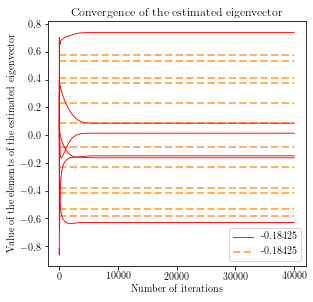

/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


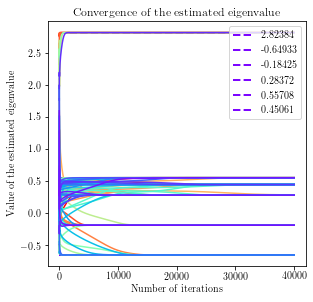

In [13]:
# Visualization
num_iter = 40000
color=iter(cm.rainbow(np.linspace(1,0,5)))
c = next(color)
fig = plt.figure();
w = 5.78851          # Latex document text width
fig.set_size_inches(w=w*0.8,h= 4.5)

for k in range(matrix_size):
    tmp_xaxis = (num_iter)
    if k==0:
        plt.plot(np.linspace(1,tmp_xaxis,tmp_xaxis),x_trial_list[:tmp_xaxis,k],c=c,label="%2.5f" % eigenvalue,linewidth=0.9)
    else:
        plt.plot(np.linspace(1,tmp_xaxis,tmp_xaxis),x_trial_list[:tmp_xaxis,k],c=c,linewidth=0.9)

## Compare with the analytical solution
print("\n Numpy Eigenvalues: \n", numpy_eigenvalue)
print("\n Final Numerical Eigenvalue \n", eigenvalue)
diff = np.min(abs(numpy_eigenvalue - eigenvalue))
print("\n")
print('Absolute difference between Numpy Eigenvalue and TensorFlow DNN = ',np.max(diff))

# Finding which element of analytic our estimated eigenvalue converges to
index = np.argmin(abs(numpy_eigenvalue - eigenvalue))

print("numpy vec:", numpy_vector[index])
print("computed vec",x_dnn.T)

c = next(color)
for l in range(matrix_size):
    plt.hlines(numpy_vector[index][l],0,num_iter,colors=c,linestyles="dashed",linewidth=2)
    if l==(matrix_size-1):
        plt.hlines(-numpy_vector[index][l],0,num_iter,colors=c,linestyles="dashed",label="%2.5f" % numpy_eigenvalue[index],linewidth=2)
        break
    plt.hlines(-numpy_vector[index][l],0,num_iter,colors=c,linestyles="dashed",linewidth=2)
plt.xlabel("Number of iterations")
plt.ylabel("Value of the elements of the estimated eigenvector")
plt.legend()
plt.title("Convergence of the estimated eigenvector")
plt.savefig("plots/eigenvalue_solver/convergence_eigenvector_random.pgf")

plt.show()

color=iter(cm.rainbow(np.linspace(1,0,run_iter+1)))
fig = plt.figure();
w = 5.78851          # Latex document text width
fig.set_size_inches(w=w*0.8,h= 4.5)


iterations=np.linspace(1,tmp_xaxis,tmp_xaxis)
for i in range(runs+1):
    plt.plot(iterations,lambdas[i][:tmp_xaxis],c=c)
    c=next(color)

for l in range(matrix_size):
    plt.hlines(numpy_eigenvalue[l],0,num_iter,colors=c,linestyles="dashed",label="%2.5f" % numpy_eigenvalue[l],linewidth=2,)
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Value of the estimated eigenvalue")
plt.title("Convergence of the estimated eigenvalue")
plt.savefig("plots/eigenvalue_solver/convergence_eigenvalue_random.pgf")

plt.show()

As seen, the values in the estimated eigenvector does not exactly converge towards numpys eigenvector when we are using a random symmetric matrix, but does however yield the exact eigenvalue. It is the eigenvalue that we are after, and since it is exact, we do not dwell about the values in the eigenvector. 

How is the counts of eigenvalues distributed?

Number of mean iterations needed: 6952.0


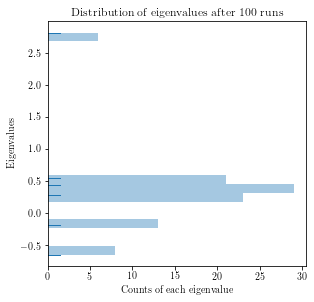

In [12]:
import seaborn as sns
fig = plt.figure();
w = 5.78851          # Latex document text width
fig.set_size_inches(w=w*0.8,h= 4.5)

#plt.hist(np.reshape(lambdas[:,-1],[1,int(run_iter)]))

plt.xlabel("Counts of each eigenvalue")
plt.ylabel("Eigenvalues")
plt.title("Distribution of eigenvalues after %2.0f runs" %(run_iter))
data= np.reshape(lambdas[:,-1],[1,int(run_iter)])
sns.distplot(data,kde=False, norm_hist=False, bins = 25, rug=True,vertical=True)
plt.savefig("plots/eigenvalue_solver/histogram_random.pgf")

print("Number of mean iterations needed:", np.mean(num_iter_needed))